In [54]:
import gym_battleship
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.dqn import CnnPolicy
from gym_battleship.environments.battleship import CHANNEL_MAP
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor
import os
from typing import Callable
import imageio

In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
hyperparameters = [
    {
        'features_dim': 128,
        'hidden_layer1': 32,
        'hidden_layer2': 64,
        'net_arch': [64, 64],
        'learning_rate': 1e-4,
        'exploration_fraction': 0.1,
        'exploration_initial_eps': 1,
        'exploration_final_eps': 0.1,
        'max_moves': 110,
        'rewards': {
            'win': 100,
            'lose': -30,
            'missed': -0.2,
            'hit': 5,
            'proximal_hit': 10,
            'repeat_missed': -50,
            'repeat_hit': -50,
        }
    },
    {
        'features_dim': 128,
        'hidden_layer1': 32,
        'hidden_layer2': 64,
        'net_arch': [64, 64],
        'learning_rate': 1e-4,
        'exploration_fraction': 0.5,
        'exploration_initial_eps': 1,
        'exploration_final_eps': 0.1,
        'max_moves': 110,
        'rewards': {
            'win': 100,
            'lose': -30,
            'missed': -0.2,
            'hit': 5,
            'proximal_hit': 10,
            'repeat_missed': -50,
            'repeat_hit': -50,
        }
    },
    {
        'features_dim': 128,
        'hidden_layer1': 32,
        'hidden_layer2': 64,
        'net_arch': [64, 64],
        'learning_rate': 1e-4,
        'exploration_fraction': 0.5,
        'exploration_initial_eps': 1,
        'exploration_final_eps': 0.1,
        'max_moves': 110,
        'rewards': {
            'win': 100,
            'lose': -30,
            'missed': 0,
            'hit': 5,
            'proximal_hit': 10,
            'repeat_missed': -50,
            'repeat_hit': -50,
        }
    },
    {
        'features_dim': 128,
        'hidden_layer1': 32,
        'hidden_layer2': 64,
        'net_arch': [64, 64],
        'learning_rate': 1e-4,
        'exploration_fraction': 0.8,
        'exploration_initial_eps': 1,
        'exploration_final_eps': 0.1,
        'max_moves': 110,
        'rewards': {
            'win': 100,
            'lose': -30,
            'missed': 0,
            'hit': 5,
            'proximal_hit': 10,
            'repeat_missed': -20,
            'repeat_hit': -20,
        }
    },
    {
        'features_dim': 128,
        'hidden_layer1': 32,
        'hidden_layer2': 64,
        'net_arch': [64, 64],
        'learning_rate': 1e-4,
        'exploration_fraction': 0.8,
        'exploration_initial_eps': 1,
        'exploration_final_eps': 0.1,
        'max_moves': 110,
        'rewards': {
            'win': 100,
            'lose': -30,
            'missed': -0.2,
            'hit': 5,
            'proximal_hit': 20,
            'repeat_missed': -20,
            'repeat_hit': -20,
        }
    },
    # final reward schema below
    {
        'features_dim': 128,
        'hidden_layer1': 32,
        'hidden_layer2': 64,
        'net_arch': [64, 64],
        'learning_rate': 1e-4,
        'exploration_fraction': 0.8,
        'exploration_initial_eps': 1,
        'exploration_final_eps': 0.1,
        'max_moves': 110,
        'rewards': {
            'win': 100,
            'lose': -30,
            'missed': -0.2,
            'hit': 5,
            'proximal_hit': 20,
            'repeat_missed': -20,
            'repeat_hit': -3, 
        }
    },
    {
        'features_dim': 128,
        'hidden_layer1': 64,
        'hidden_layer2': 128,
        'net_arch': [128, 128],
        'learning_rate': 1e-4,
        'exploration_fraction': 0.8,
        'exploration_initial_eps': 1,
        'exploration_final_eps': 0.1,
        'max_moves': 110,
        'rewards': {
            'win': 100,
            'lose': -30,
            'missed': -0.2,
            'hit': 5,
            'proximal_hit': 20,
            'repeat_missed': -20,
            'repeat_hit': -3, 
        }
    },
    {
        'features_dim': 256,
        'hidden_layer1': 64,
        'hidden_layer2': 128,
        'net_arch': [256, 256],
        'learning_rate': 1e-4,
        'exploration_fraction': 0.8,
        'exploration_initial_eps': 1,
        'exploration_final_eps': 0.1,
        'max_moves': 110,
        'rewards': {
            'win': 100,
            'lose': -30,
            'missed': -0.2,
            'hit': 5,
            'proximal_hit': 20,
            'repeat_missed': -20,
            'repeat_hit': -3, 
        }
    },
    {
        'features_dim': 256,
        'hidden_layer1': 128,
        'hidden_layer2': 256,
        'net_arch': [256, 256],
        'learning_rate': 1e-4,
        'exploration_fraction': 0.8,
        'exploration_initial_eps': 1,
        'exploration_final_eps': 0.1,
        'max_moves': 110,
        'rewards': {
            'win': 100,
            'lose': -30,
            'missed': -0.2,
            'hit': 5,
            'proximal_hit': 20,
            'repeat_missed': -20,
            'repeat_hit': -3, 
        }
    },
    {
        'features_dim': 256,
        'hidden_layer1': 128,
        'hidden_layer2': 256,
        'net_arch': [256, 256],
        'learning_rate': 1e-4,
        'exploration_fraction': 0.4,
        'exploration_initial_eps': 1,
        'exploration_final_eps': 0.1,
        'max_moves': 110,
        'rewards': {
            'win': 100,
            'lose': -30,
            'missed': -0.2,
            'hit': 5,
            'proximal_hit': 20,
            'repeat_missed': -20,
            'repeat_hit': -3, 
        }
    },
]

In [57]:
def make_battleship_cnn(features_dim: int, hidden_layer1: int, hidden_layer2: int):
    class BattleshipCNN(BaseFeaturesExtractor):
        def __init__(self, observation_space, features_dim=features_dim):
            super().__init__(observation_space, features_dim)

            n_channels = observation_space.shape[0]  

            self.cnn = nn.Sequential(
                nn.Conv2d(n_channels, hidden_layer1, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(hidden_layer1, hidden_layer2, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Flatten()
            )

            with th.no_grad():
                sample = th.zeros((1, n_channels, 10, 10))
                sample_out = self.cnn(sample)
                conv_output_dim = sample_out.shape[1]

            self.linear = nn.Sequential(
                nn.Linear(conv_output_dim, features_dim),
                nn.ReLU()
            )

        def forward(self, obs):
            return self.linear(self.cnn(obs))
    
    return BattleshipCNN


In [58]:
def plot_q_value_heatmap(q_values, title="Q-Value Heatmap", image=False):
    q_vals = q_values[0].cpu().numpy()
    
    grid = np.zeros((10, 10))
    for i in range(100):
        row = i // 10
        col = i % 10
        grid[row, col] = q_vals[i]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(grid, cmap='coolwarm', aspect='auto')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Q-Value', rotation=270, labelpad=20)
    
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xticklabels(np.arange(10))
    ax.set_yticklabels(np.arange(10))
    
    ax.set_xticks(np.arange(10) - 0.5, minor=True)
    ax.set_yticks(np.arange(10) - 0.5, minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    ax.set_title(title)
    
    for i in range(10):
        for j in range(10):
            text = ax.text(j, i, f'{grid[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=8)
    
    plt.tight_layout()
    
    if image:
        # Convert plot to image array
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        # Convert RGBA to RGB
        img = img[:, :, :3]
        plt.close(fig)
        return img
    else:
        plt.show()
        return grid

In [59]:
def masked_predict(model, obs):
    """Choose action with highest Q-value among legal actions"""
    obs_tensor = th.as_tensor(obs).unsqueeze(0).float()
    
    with th.no_grad():
        q_values = model.q_net(obs_tensor)
        
    legal_mask = (obs[CHANNEL_MAP.LEGAL_MOVE.value, :, :] == 0).flatten()
    
    # set illegal actions to very negative Q-value
    q_values_masked = q_values.clone()
    q_values_masked[0, ~legal_mask] = -float('inf')
    action = q_values_masked.argmax(dim=1).item()

    return action, q_values

In [60]:
def get_q_values(model, obs):
    """Get Q-values for all actions given a state"""
    obs_tensor = th.as_tensor(obs).unsqueeze(0).float()
    
    with th.no_grad():
        q_values = model.q_net(obs_tensor)

    return q_values

In [61]:

class TrainingMetricsCallback(BaseCallback):
    
    def __init__(self, check_freq: int = 100, verbose=0):
        super(TrainingMetricsCallback, self).__init__(verbose)
        self.check_freq = check_freq # number of episodes we're averaging over for mean reward and game length
        self.ep_rew_means = []
        self.ep_len_means = []
        self.episodes = []
        self.current_episode_count = 0
        
    def _on_step(self) -> bool:
        # max length of ep_info_buffer is 100 by default
        if len(self.model.ep_info_buffer) == self.check_freq:
            self.current_episode_count += self.check_freq
            
            new_episodes = list(self.model.ep_info_buffer)[:self.check_freq]
            for _ in range(self.check_freq):
                self.model.ep_info_buffer.popleft() # remove episodes we've seen
                
            ep_means = [ep['r'] for ep in new_episodes]
            ep_lens = [ep['l'] for ep in new_episodes]
            
            ep_rew_mean = np.mean(ep_means)
            ep_len_mean = np.mean(ep_lens)
            
            self.ep_rew_means.append(ep_rew_mean)
            self.ep_len_means.append(ep_len_mean)
            self.episodes.append(self.current_episode_count)
            
            if self.verbose > 0:
                print(f"Current episode count: {self.current_episode_count}: "
                        f"Mean reward = {ep_rew_mean:.2f}, Mean length = {ep_len_mean:.2f} for past {self.check_freq} episodes.")
                    
        return True


def plot_training_metrics(callback, hyperparameter_index):
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(callback.episodes, callback.ep_rew_means, 'b-')
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Episode Reward Mean')
    ax1.set_title(f'Model {hyperparameter_index}: Episode Reward Mean')
    ax1.grid(True)
    plt.tight_layout()
    fig1.savefig(f'./dqn_models/model-{hyperparameter_index}-reward.png', dpi=150)
    plt.show()
    plt.close(fig1)
    
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    ax2.plot(callback.episodes, callback.ep_len_means, 'r-')
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Mean Episode Length')
    ax2.set_title(f'Model {hyperparameter_index}: Episode Length Mean')
    ax2.grid(True)
    plt.tight_layout()
    fig2.savefig(f'./dqn_models/model-{hyperparameter_index}-length.png', dpi=150)
    plt.show()
    plt.close(fig2)
    


In [ ]:
with open("dqn-training.txt", "a") as f:
    for index, hyperparameter in enumerate(hyperparameters):
        env = gym.make('Battleship-v0', board_size=(10, 10), reward_dictionary=hyperparameter['rewards'], episode_steps=hyperparameter['max_moves'])
        env.reset()

        CustomCNN = make_battleship_cnn(
            hyperparameter['features_dim'],
            hyperparameter['hidden_layer1'],
            hyperparameter['hidden_layer2']
        )

        policy_kwargs = dict(
            features_extractor_class=CustomCNN,
            features_extractor_kwargs=dict(features_dim=hyperparameter['features_dim']),
            net_arch=hyperparameter['net_arch'],
            normalize_images=False
        )

        model = DQN(
            "CnnPolicy",
            env,
            policy_kwargs=policy_kwargs,
            learning_rate=hyperparameter['learning_rate'],
            # adjustable parameters
            exploration_fraction=hyperparameter['exploration_fraction'],
            exploration_initial_eps=hyperparameter['exploration_initial_eps'],
            exploration_final_eps=hyperparameter['exploration_final_eps'],
            verbose=0,
        )
        
        # Create callback to track training metrics
        metrics_callback = TrainingMetricsCallback(check_freq=10)
        
        model.learn(total_timesteps=200000, log_interval=10, callback=metrics_callback)
        model.save(f"./dqn_models-test1/dqn-{index + 1}")
        
        # Plot training metrics
        plot_training_metrics(metrics_callback, index + 1)
        

In [73]:
def plot_histogram(ratios, title="Histogram", x_label="X axis", y_label="Y axis", save_path=None):
    """
    Create a histogram of hit-to-miss ratios for a model
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create histogram
    ax.hist(ratios, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    
    # Add labels and title
    # ax.set_xlabel('Hit-to-Miss Ratio')
    # ax.set_ylabel('Frequency')
    # ax.set_title(f'Model {model_index} Hit-to-Miss Ratio Distribution')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    
    # Add statistics to the plot
    mean_ratio = np.mean(ratios)
    median_ratio = np.median(ratios)
    ax.axvline(mean_ratio, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_ratio:.3f}')
    ax.axvline(median_ratio, color='green', linestyle='--', linewidth=2, label=f'Median: {median_ratio:.3f}')
    ax.legend()
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=150)
    
    plt.show()
    plt.close(fig)

In [79]:
def plot_action_distribution(action_dict, title="Action Distribution", x_label="Action (Grid Position)", y_label="Frequency", display=True, save_path=None):
    """
    Create a histogram showing the distribution of actions taken
    
    Args:
        action_dict: Dictionary mapping action (int) to frequency (int)
        title: Title for the plot
        x_label: Label for x-axis
        y_label: Label for y-axis
        save_path: Optional path to save the figure
    """
    if not action_dict:
        print("No action distribution data to plot")
        return
    
    # Sort actions for consistent plotting
    actions = sorted(action_dict.keys())
    frequencies = [action_dict[action] for action in actions]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create bar chart
    bars = ax.bar(actions, frequencies, edgecolor='black', alpha=0.7, color='steelblue')
    
    # Add labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add statistics
    total_actions = sum(frequencies)
    mean_freq = np.mean(frequencies)
    ax.axhline(mean_freq, color='red', linestyle='--', linewidth=2, 
               label=f'Mean Frequency: {mean_freq:.1f}')
    ax.legend()
    
    # Optionally add value labels on top of bars if not too many actions
    if len(actions) <= 100:
        for i, (action, freq) in enumerate(zip(actions, frequencies)):
            if freq > mean_freq * 1.5:  # Only label significant bars
                ax.text(action, freq, str(freq), ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=150)
    
    if display:
        plt.show()
    plt.close(fig)

In [110]:
from heuristic_agent import HeuristicAgent

def run_games(model, env, num_games=1000, mask=True, root_dir=None): 
    env.reset()
    num_lost = 0
    num_wins = 0
    num_steps = 0
    total_reward = 0
    num_hits = 0
    num_misses = 0
    action_distributions = []
    total_action_distribution = {}
    num_moves_distribution = []
    hit_to_miss_ratios = []
    sample_freq = num_games / 5

    for game in range(1, num_games + 1):
        obs, info = env.reset()
        sampling_action_distribution = True if (game % sample_freq == 0) else False
        action_distributions.append({}) if sampling_action_distribution else None
        game_hits = 0
        game_misses = 0
        
        if isinstance(model, HeuristicAgent):
            model = HeuristicAgent(env, skip_invalid_actions=True)
        
        for _ in range(110):
            if mask:
                action, _ = masked_predict(model, obs)
            else:
                action, _states = model.predict(obs)
                action = int(action)
            if sampling_action_distribution:
                action_distributions[-1][action] = action_distributions[-1].get(action, 0) + 1
            total_action_distribution[action] = total_action_distribution.get(action, 0) + 1
                
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            num_steps += 1
            
            if reward == env.unwrapped.reward_dictionary['hit'] or reward == env.unwrapped.reward_dictionary['proximal_hit'] or reward == env.unwrapped.reward_dictionary['win']:
                num_hits += 1
                game_hits += 1
            else: 
                num_misses += 1
                game_misses += 1
            
            if truncated: 
                num_lost += 1
                num_moves_distribution.append(game_hits + game_misses)
                hit_to_miss_ratios.append(game_hits / game_misses if game_misses > 0 else float('inf'))
                break
                
            if terminated:
                num_wins += 1
                num_moves_distribution.append(game_hits + game_misses)
                hit_to_miss_ratios.append(game_hits / game_misses if game_misses > 0 else float('inf'))
                break
    
    plot_histogram(hit_to_miss_ratios, 
                   title=f"Hit-to-Miss Ratio Distribution ({'Masking' if mask else 'Non-Masking'})", 
                   x_label="Hit-to-Miss Ratio", 
                   y_label="Frequency", 
                   save_path=f"{root_dir}/hit_to_miss_ratio_histogram_{'masking' if mask else 'non_masking'}.png"
                #    save_path=f"./dqn_models/dqn_model_{index + 1}/hit_to_miss_ratio_histogram_{'masking' if mask else 'non_masking'}.png")
    )
    
    plot_histogram(num_moves_distribution, 
                   title=f"Number of Moves Distribution ({'Masking' if mask else 'Non-Masking'})", 
                   x_label="Number of Moves", 
                   y_label="Frequency", 
                   save_path=f"{root_dir}/num_moves_histogram_{'masking' if mask else 'non_masking'}.png"
                #    save_path=f"./dqn_models/dqn_model_{index + 1}/num_moves_histogram_{'masking' if mask else 'non_masking'}.png")
    )
    
    plot_action_distribution(total_action_distribution, title=f"Action Distribution ({'Masking' if mask else 'Non-Masking'})", 
                                x_label="Action (Grid Position)", y_label="Frequency", 
                                save_path=f"{root_dir}/action_distribution_{'masking' if mask else 'non_masking'}.png"
                                # save_path=f"./dqn_models/dqn_model_{index + 1}/action_distribution_{'masking' if mask else 'non_masking'}.png")
    )
    
    for i, action_dist in enumerate(action_distributions):
        plot_action_distribution(action_dist, 
                                 title=f"Action Distribution Sample {i + 1} ({'Masking' if mask else 'Non-Masking'})", 
                                 x_label="Action (Grid Position)", 
                                 y_label="Frequency", 
                                 display=False,
                                 save_path=f"{root_dir}/action_distribution_sample_{i + 1}_{'masking' if mask else 'non_masking'}.png"
                                #  save_path=f"./dqn_models/dqn_model_{index + 1}/action_distribution_sample_{i + 1}_{'masking' if mask else 'non_masking'}.png")
        )
    return {
        "num_wins": num_wins,
        "num_lost": num_lost,
        "num_hits": num_hits,
        "num_misses": num_misses,
        "average-hit-to-miss-ratio": num_hits / num_misses if num_misses > 0 else float('inf'),
        "win_rate": num_wins / num_games,
        "avg_steps": num_steps / num_games,
        "avg_reward": total_reward / num_games,
        "action_distribution_samples": action_distributions
    }
    


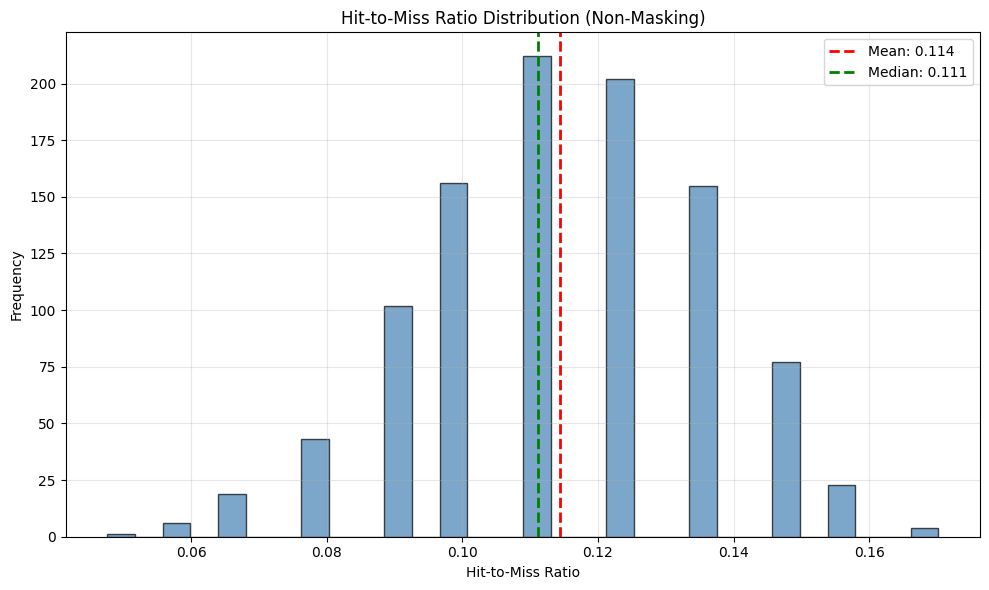

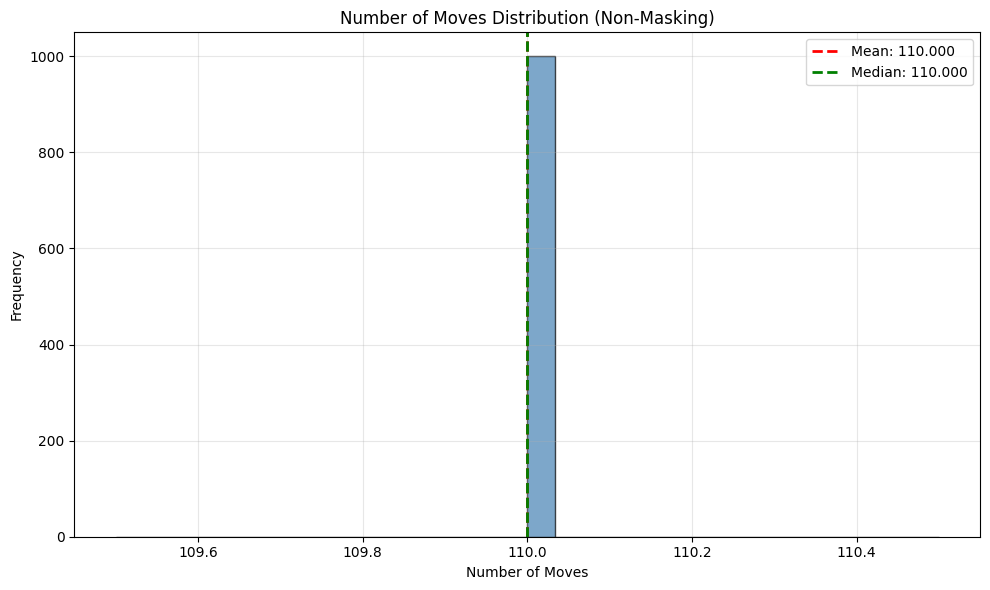

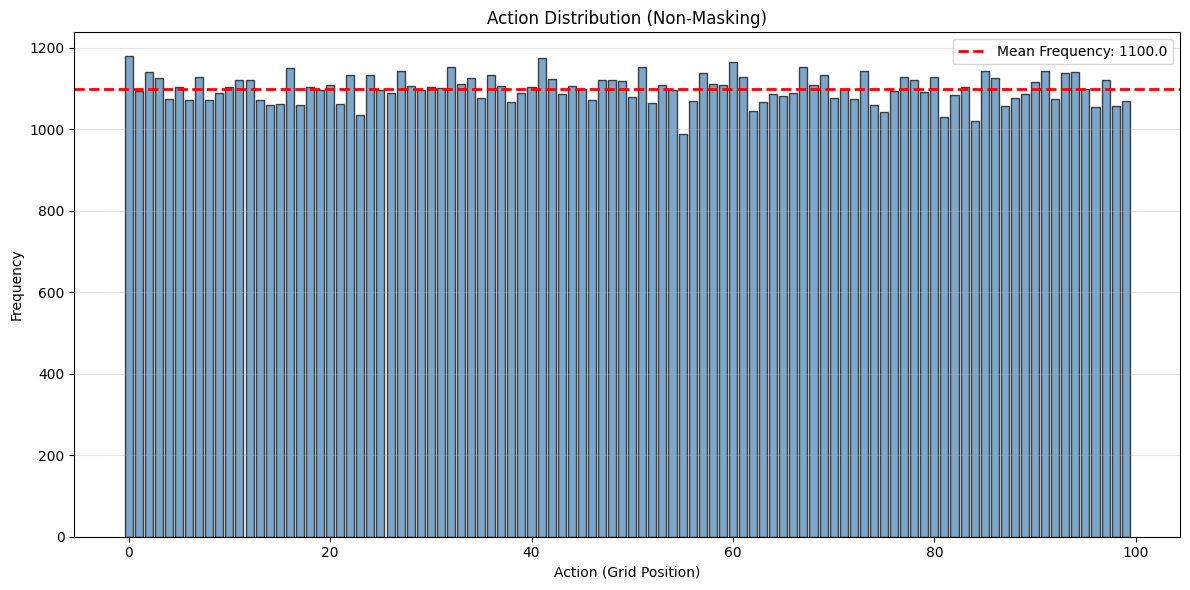

Random agent results: 
{'num_wins': 0, 'num_lost': 1000, 'num_hits': 11254, 'num_misses': 98746, 'average-hit-to-miss-ratio': 0.11396917343487331, 'win_rate': 0.0, 'avg_steps': 110.0, 'avg_reward': -638.8403999999193, 'action_distribution_samples': [{14: 2, 4: 1, 76: 5, 66: 2, 83: 3, 37: 2, 46: 3, 30: 1, 65: 1, 0: 5, 61: 3, 54: 1, 25: 1, 70: 2, 23: 1, 38: 2, 36: 2, 17: 2, 84: 2, 80: 3, 55: 1, 1: 2, 67: 1, 72: 2, 50: 3, 10: 5, 16: 2, 42: 3, 3: 1, 68: 1, 19: 2, 88: 2, 45: 1, 79: 1, 26: 2, 62: 4, 53: 1, 82: 2, 92: 1, 86: 2, 48: 3, 35: 1, 60: 3, 93: 1, 18: 1, 89: 1, 49: 1, 69: 1, 58: 1, 11: 2, 9: 1, 28: 1, 13: 3, 81: 1, 71: 1, 95: 1, 77: 1, 74: 1, 20: 1, 29: 1}, {58: 1, 86: 1, 75: 5, 84: 1, 34: 3, 68: 2, 91: 2, 50: 1, 19: 1, 10: 1, 43: 1, 30: 1, 28: 2, 97: 1, 74: 1, 56: 2, 78: 2, 59: 3, 17: 3, 18: 3, 63: 3, 29: 1, 87: 2, 1: 2, 32: 1, 47: 2, 88: 1, 99: 3, 98: 2, 25: 1, 71: 1, 31: 3, 54: 1, 61: 2, 79: 2, 70: 1, 27: 1, 96: 1, 57: 1, 36: 2, 66: 2, 90: 3, 81: 1, 22: 1, 45: 1, 14: 2, 21: 3, 15: 

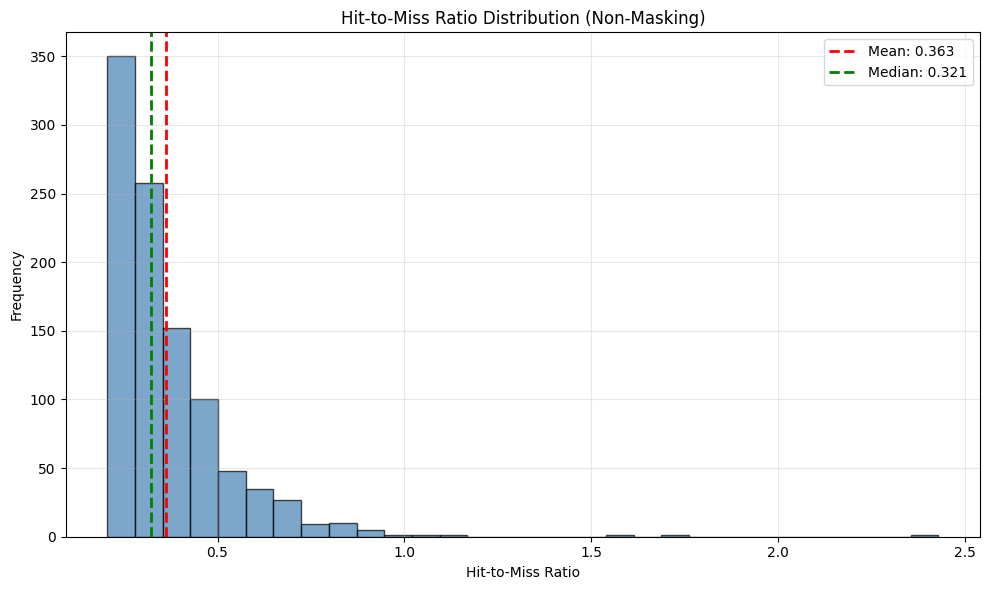

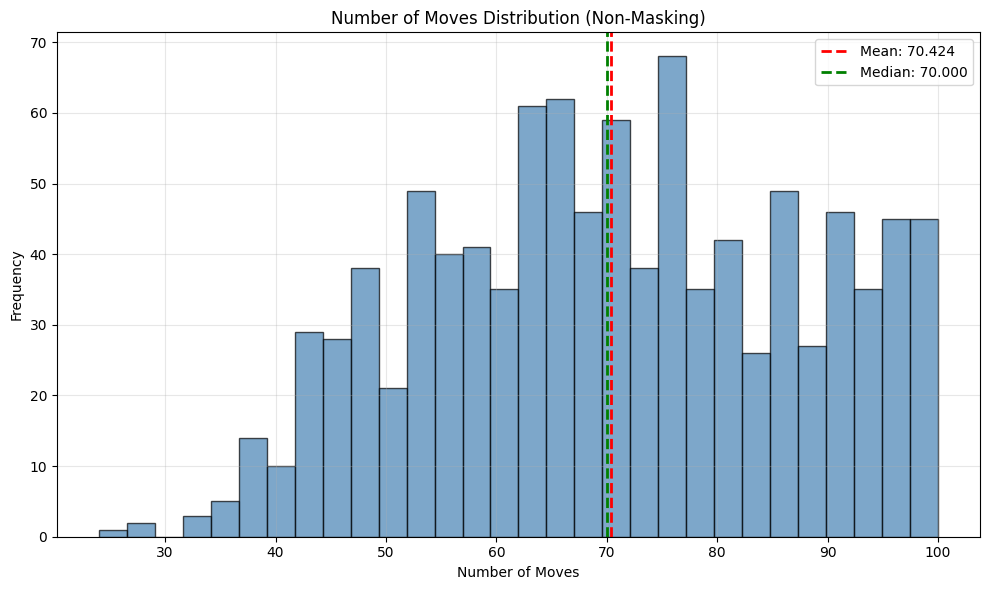

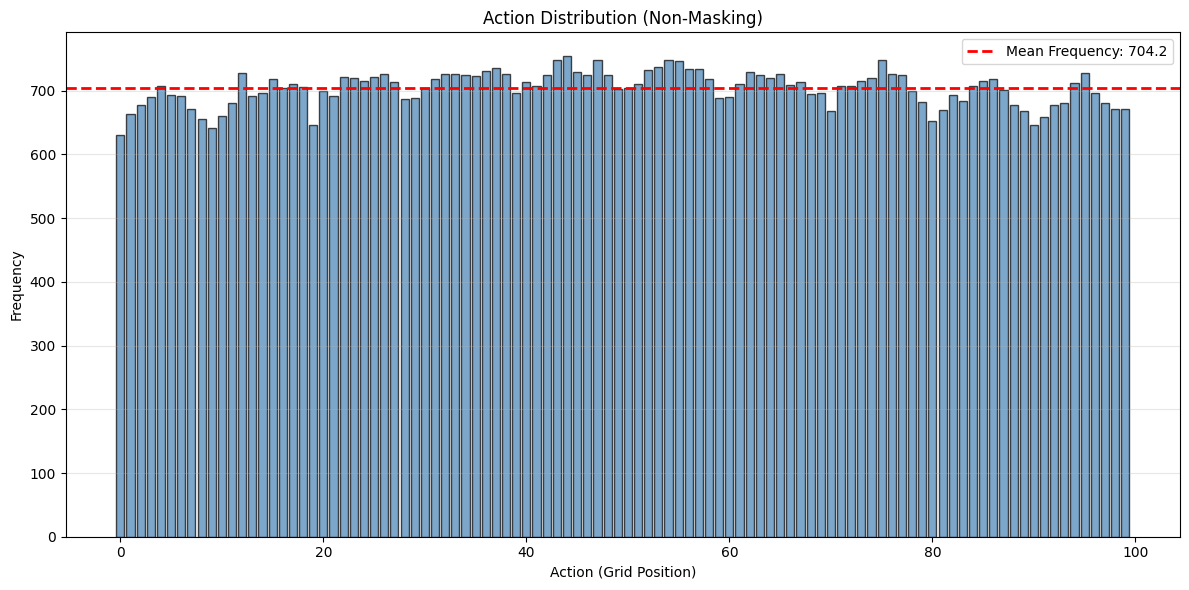

Heuristic agent results: 
{'num_wins': 1000, 'num_lost': 0, 'num_hits': 17000, 'num_misses': 53424, 'average-hit-to-miss-ratio': 0.31820904462413896, 'win_rate': 1.0, 'avg_steps': 70.424, 'avg_reward': 343.7951999996501, 'action_distribution_samples': [{20: 1, 75: 1, 46: 1, 65: 1, 86: 1, 67: 1, 96: 1, 92: 1, 36: 1, 13: 1, 1: 1, 37: 1, 51: 1, 7: 1, 8: 1, 6: 1, 5: 1, 4: 1, 82: 1, 83: 1, 81: 1, 80: 1, 94: 1, 74: 1, 73: 1, 84: 1, 64: 1, 54: 1, 44: 1, 34: 1, 22: 1, 30: 1, 77: 1, 85: 1, 9: 1, 3: 1, 42: 1, 17: 1, 89: 1, 25: 1, 76: 1, 0: 1, 21: 1, 12: 1, 50: 1, 60: 1, 70: 1, 40: 1, 38: 1, 72: 1, 62: 1, 39: 1, 15: 1, 10: 1, 27: 1, 87: 1, 45: 1, 90: 1, 19: 1, 91: 1, 23: 1, 29: 1, 48: 1, 66: 1, 33: 1, 79: 1, 78: 1, 14: 1, 32: 1, 26: 1, 93: 1, 16: 1, 58: 1, 59: 1, 57: 1, 56: 1, 55: 1}, {60: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 92: 1, 91: 1, 58: 1, 2: 1, 30: 1, 51: 1, 20: 1, 13: 1, 89: 1, 88: 1, 87: 1, 86: 1, 85: 1, 70: 1, 56: 1, 57: 1, 55: 1, 66: 1, 46: 1, 36: 1, 26: 1, 21: 1, 22: 1, 31: 1, 11: 1

In [112]:
# evaluate hardcoded algorithms
from random_agent import RandomAgent
from heuristic_agent import HeuristicAgent

NUM_GAMES = 1000

env = gym.make('Battleship-v0', board_size=(10, 10))

random_agent = RandomAgent(skip_invalid_actions=False)

# 1000 games with action masking and 1000 without action masking
random_agent_results = run_games(random_agent, env, num_games=NUM_GAMES, mask=False, root_dir="./hardcoded_models/random_agent")
print("Random agent results: ")
print(random_agent_results)

env.reset()
heuristic_agent = HeuristicAgent(env, skip_invalid_actions=True)
heuristic_agent_results = run_games(heuristic_agent, env, num_games=NUM_GAMES, mask=False, root_dir="./hardcoded_models/heuristic_agent")

print("Heuristic agent results: ")
print(heuristic_agent_results)

with open (f"./hardcoded_models/random_agent/random_agent_results.txt", "a") as f:
    f.write("\t" + str(random_agent_results) + "\n")
    f.flush()

with open (f"./hardcoded_models/heuristic_agent/heuristic_agent_results.txt", "a") as f:
    f.write("\t" + str(heuristic_agent_results) + "\n")
    f.flush()

/Users/shayanhalder/Library/CloudStorage/OneDrive-Personal/UCI/ICS/CS 175/Project/gym-battleship/venv/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.42GB > 1.70GB
  warnings.warn(


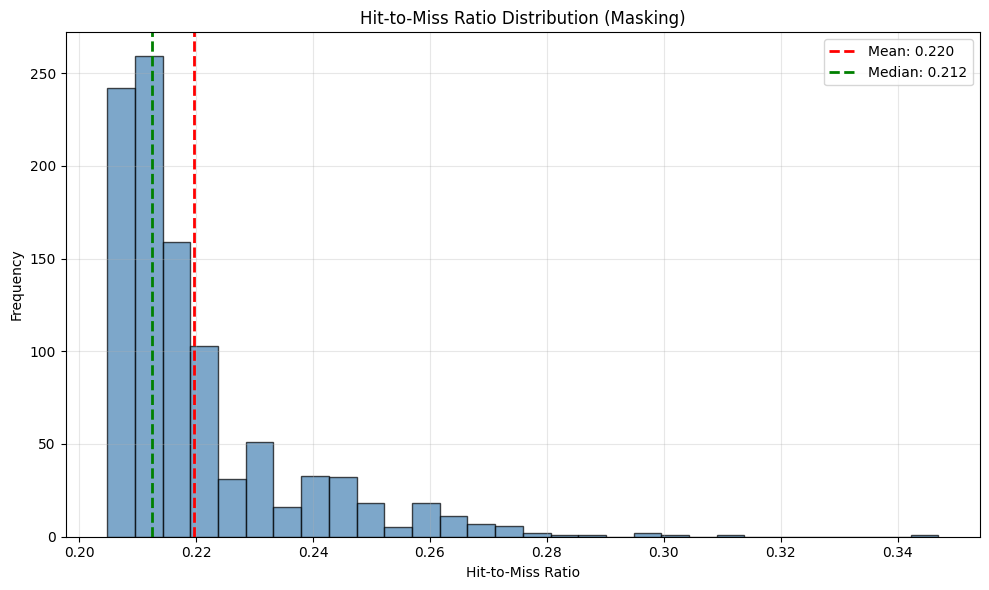

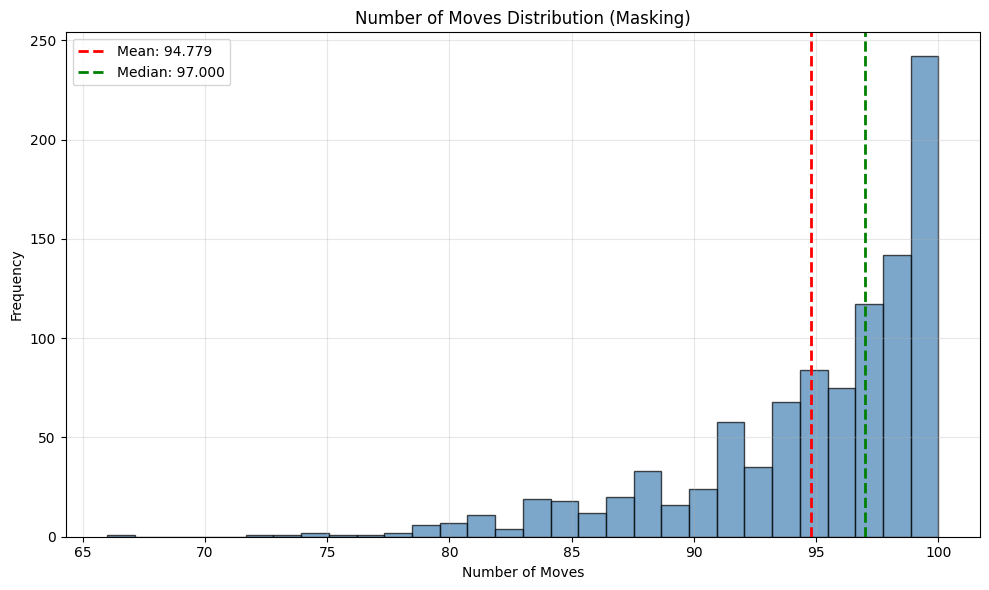

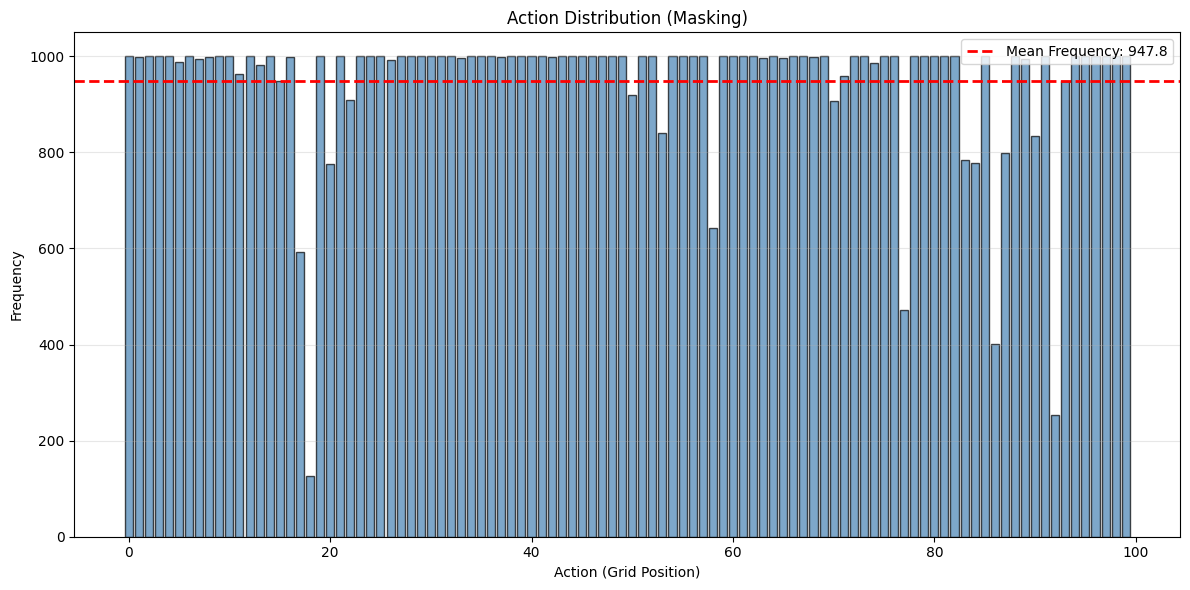

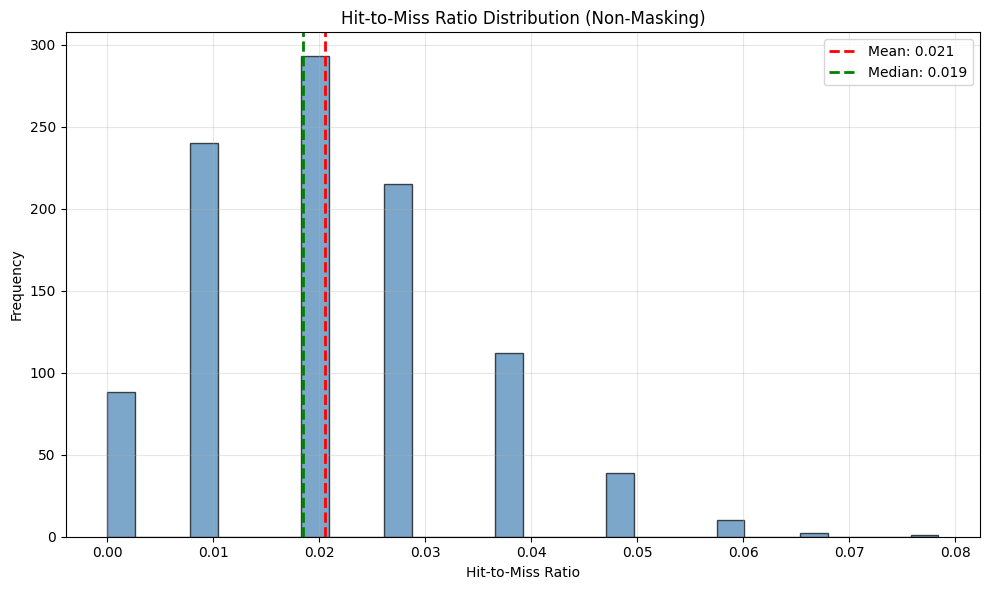

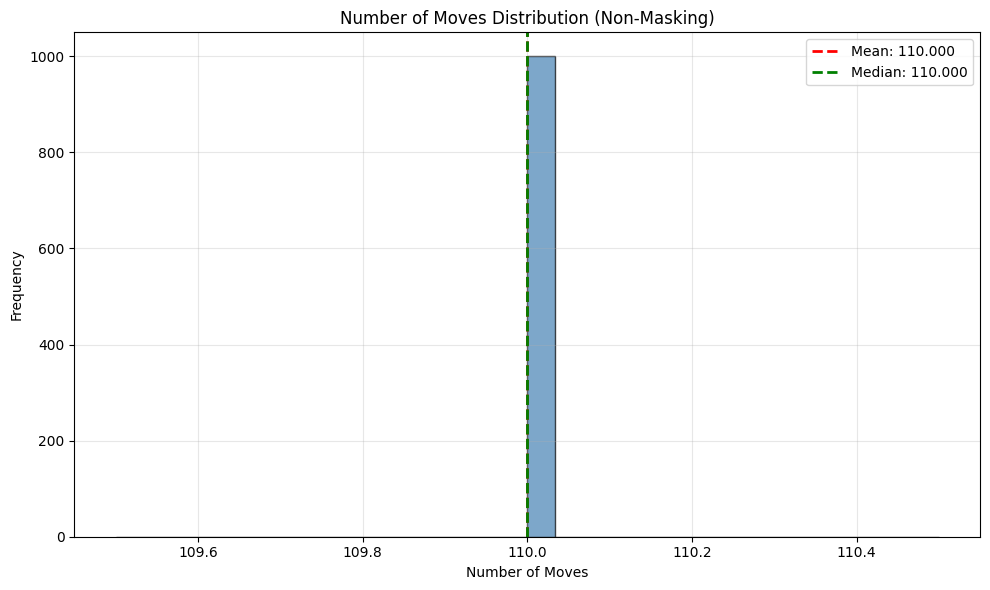

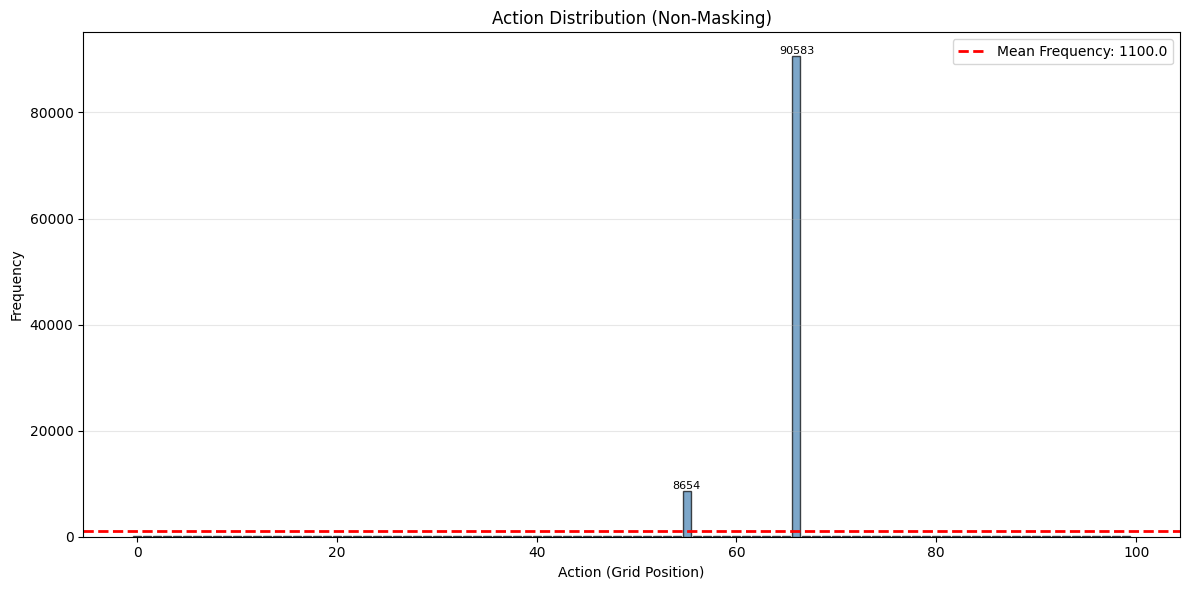

-----------------------------
Model 1 results: 
Action masking results (1000 games):
{'num_wins': 1000, 'num_lost': 0, 'num_hits': 17000, 'num_misses': 77779, 'average-hit-to-miss-ratio': 0.21856799393152393, 'win_rate': 1.0, 'avg_steps': 94.779, 'avg_reward': 295.2741999995661, 'action_distribution_samples': [{55: 1, 66: 1, 97: 1, 47: 1, 43: 1, 79: 1, 44: 1, 23: 1, 29: 1, 67: 1, 39: 1, 30: 1, 52: 1, 80: 1, 72: 1, 9: 1, 99: 1, 35: 1, 27: 1, 82: 1, 57: 1, 75: 1, 4: 1, 73: 1, 14: 1, 91: 1, 51: 1, 24: 1, 0: 1, 95: 1, 78: 1, 64: 1, 36: 1, 10: 1, 28: 1, 12: 1, 21: 1, 40: 1, 46: 1, 98: 1, 48: 1, 34: 1, 38: 1, 59: 1, 88: 1, 41: 1, 85: 1, 32: 1, 61: 1, 94: 1, 2: 1, 19: 1, 76: 1, 60: 1, 6: 1, 45: 1, 49: 1, 25: 1, 69: 1, 3: 1, 56: 1, 96: 1, 81: 1, 68: 1, 54: 1, 8: 1, 62: 1, 16: 1, 42: 1, 31: 1, 37: 1, 65: 1, 33: 1, 1: 1, 26: 1, 63: 1, 7: 1, 89: 1, 13: 1, 74: 1, 5: 1, 71: 1, 11: 1, 15: 1, 93: 1, 50: 1, 70: 1}, {55: 1, 66: 1, 97: 1, 47: 1, 43: 1, 79: 1, 44: 1, 23: 1, 29: 1, 67: 1, 39: 1, 30: 1, 80

/Users/shayanhalder/Library/CloudStorage/OneDrive-Personal/UCI/ICS/CS 175/Project/gym-battleship/venv/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.42GB > 1.58GB
  warnings.warn(


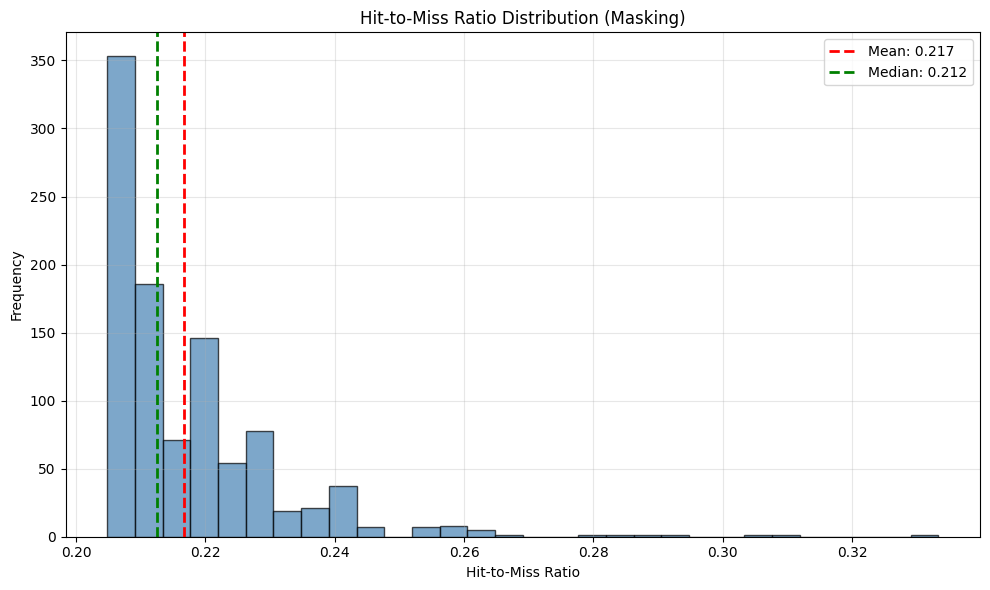

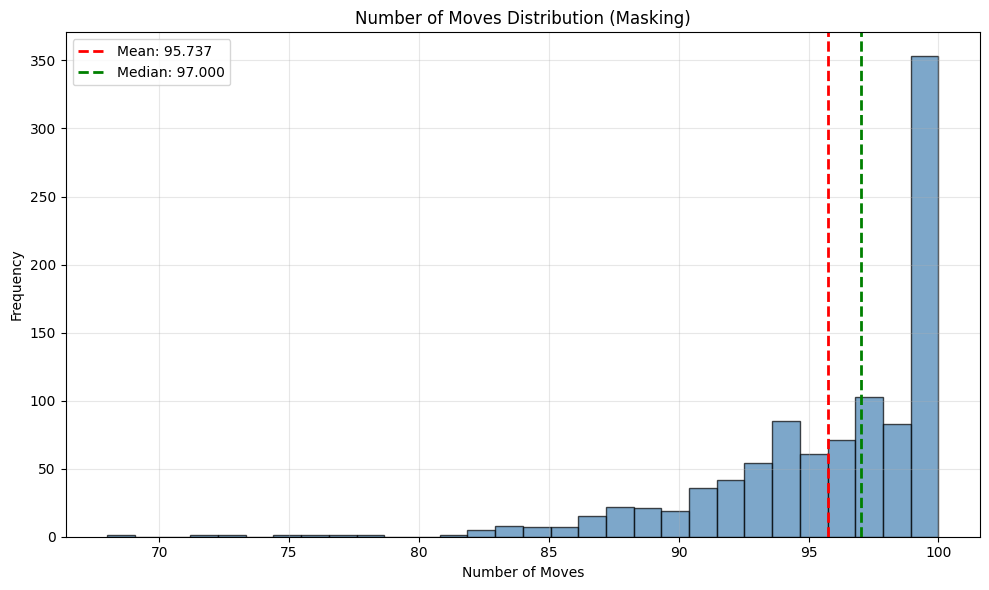

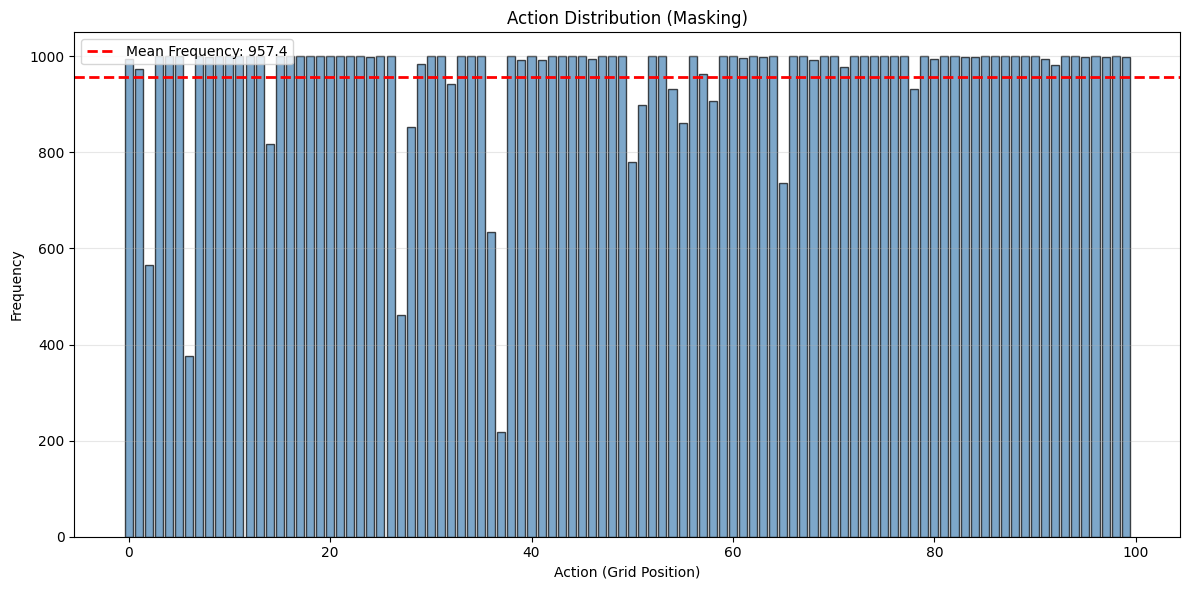

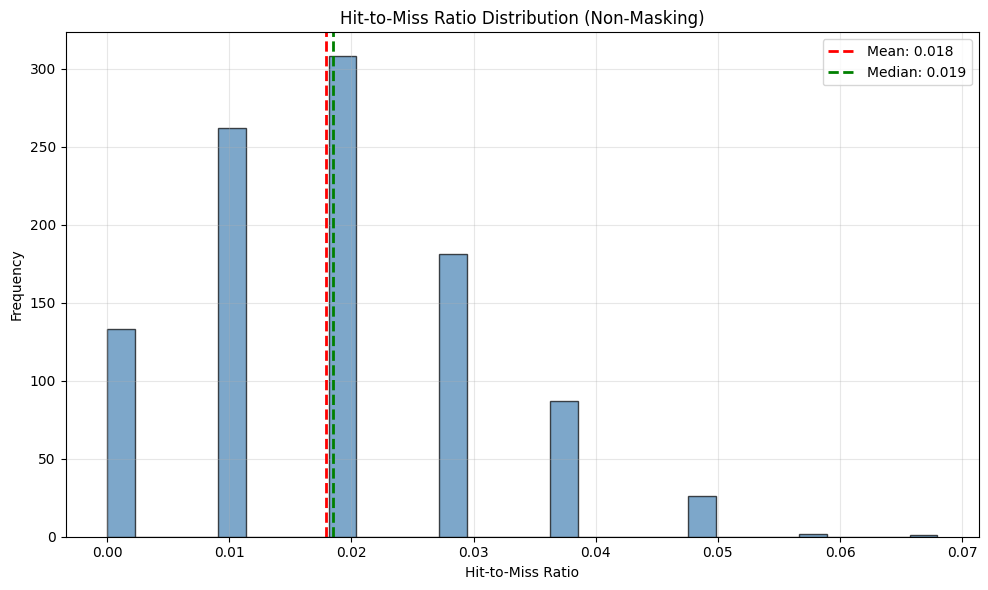

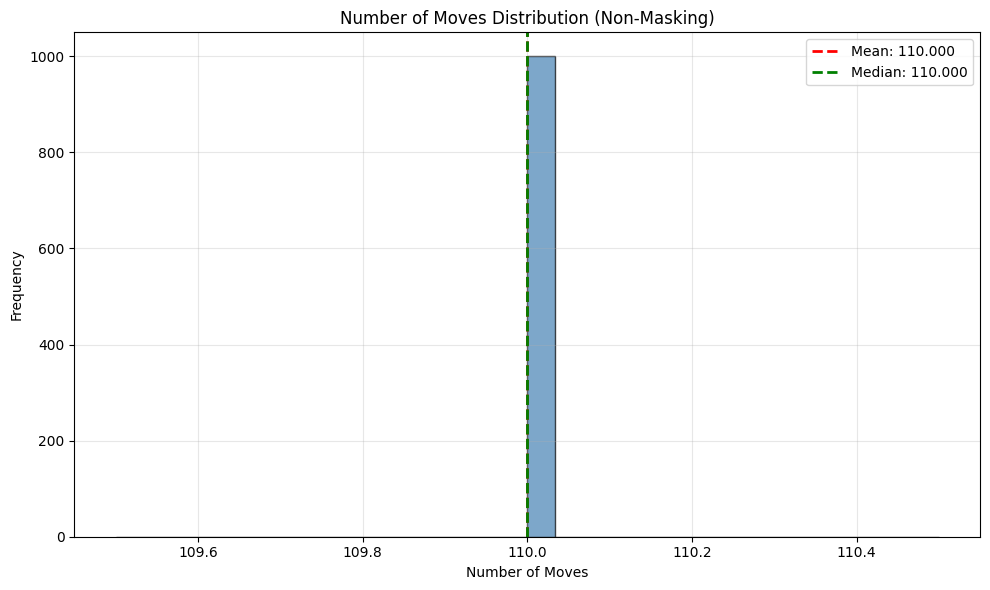

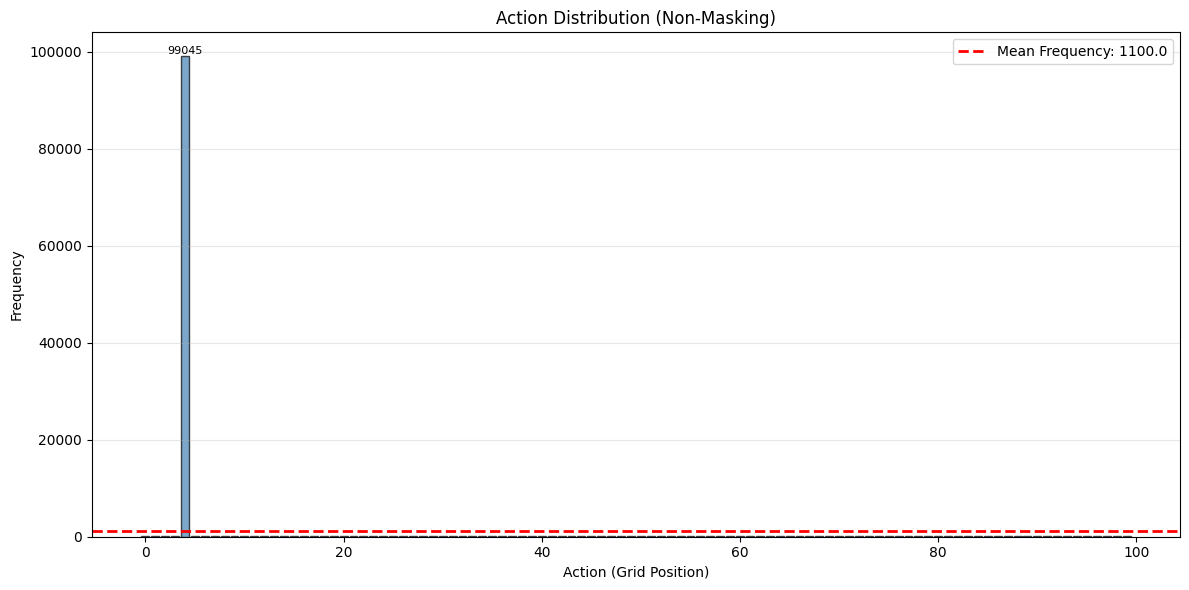

-----------------------------
Model 2 results: 
Action masking results (1000 games):
{'num_wins': 1000, 'num_lost': 0, 'num_hits': 17000, 'num_misses': 78737, 'average-hit-to-miss-ratio': 0.21590865793718328, 'win_rate': 1.0, 'avg_steps': 95.737, 'avg_reward': 302.8675999995534, 'action_distribution_samples': [{4: 1, 90: 1, 21: 1, 87: 1, 93: 1, 72: 1, 17: 1, 64: 1, 52: 1, 16: 1, 25: 1, 74: 1, 18: 1, 86: 1, 12: 1, 40: 1, 10: 1, 26: 1, 5: 1, 44: 1, 59: 1, 62: 1, 81: 1, 13: 1, 53: 1, 79: 1, 75: 1, 31: 1, 23: 1, 88: 1, 38: 1, 67: 1, 60: 1, 15: 1, 33: 1, 9: 1, 42: 1, 55: 1, 78: 1, 66: 1, 20: 1, 98: 1, 83: 1, 48: 1, 56: 1, 11: 1, 85: 1, 47: 1, 45: 1, 49: 1, 30: 1, 77: 1, 3: 1, 70: 1, 19: 1, 89: 1, 7: 1, 43: 1, 76: 1, 94: 1, 69: 1, 73: 1, 22: 1, 34: 1, 96: 1, 97: 1, 35: 1, 8: 1, 82: 1, 63: 1, 99: 1, 84: 1, 95: 1, 41: 1, 61: 1, 0: 1, 80: 1, 39: 1, 24: 1, 91: 1, 46: 1, 68: 1, 92: 1, 29: 1, 71: 1, 1: 1, 57: 1, 58: 1, 54: 1, 32: 1, 51: 1, 28: 1, 14: 1}, {4: 1, 90: 1, 21: 1, 87: 1, 93: 1, 72: 1, 1

/Users/shayanhalder/Library/CloudStorage/OneDrive-Personal/UCI/ICS/CS 175/Project/gym-battleship/venv/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.42GB > 1.35GB
  warnings.warn(


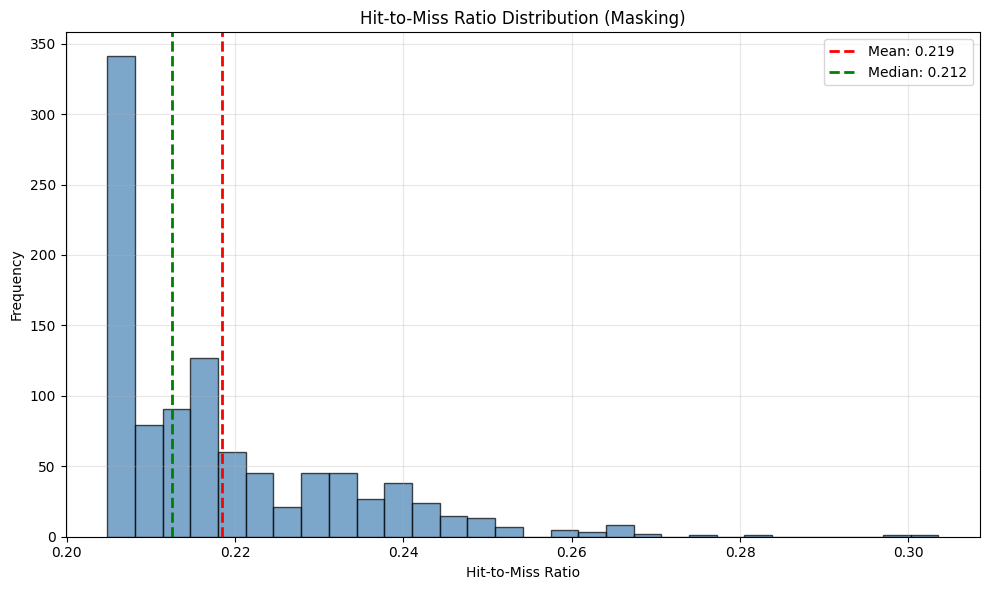

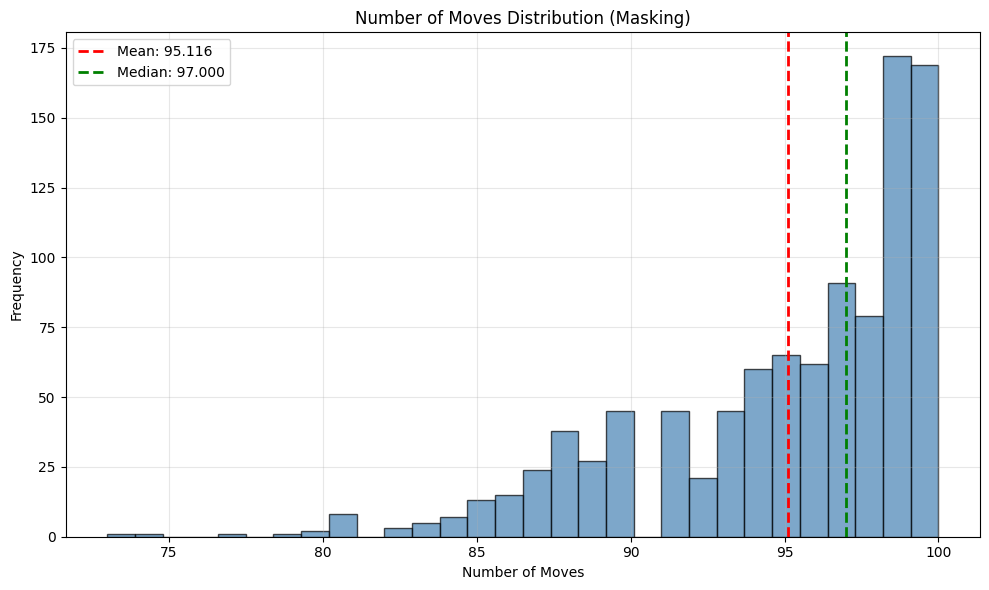

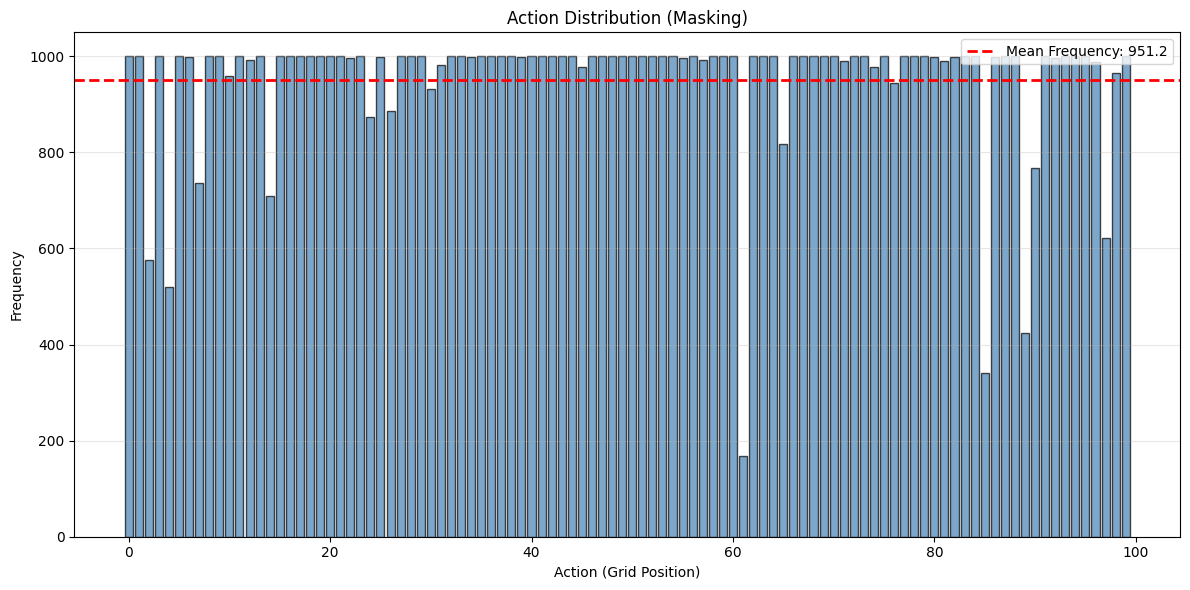

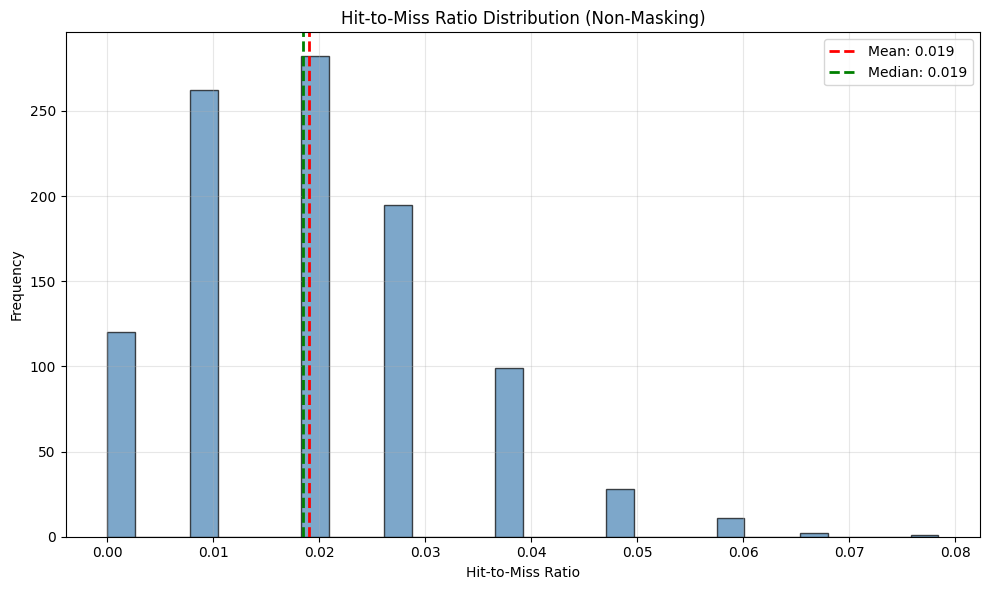

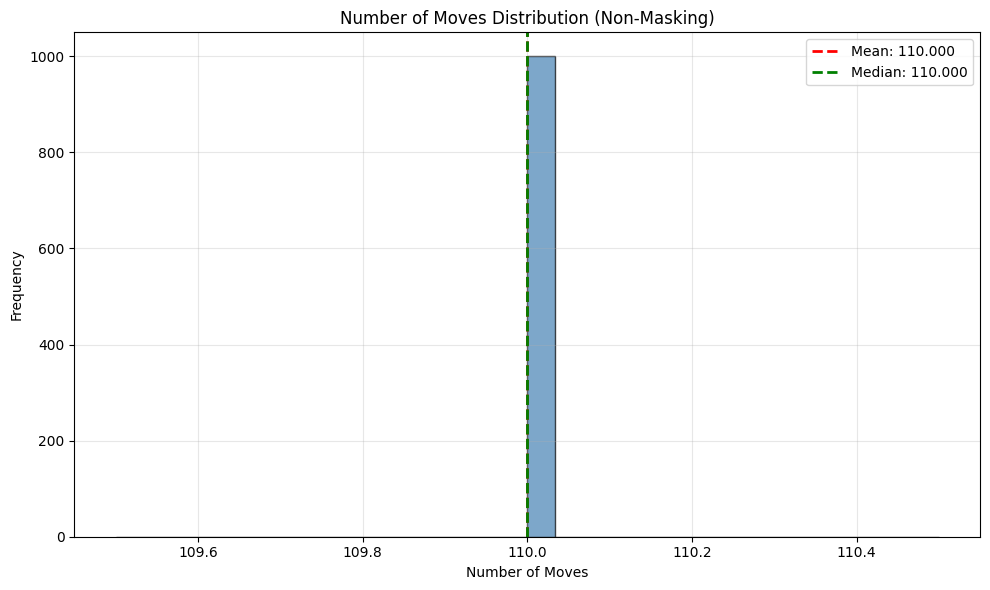

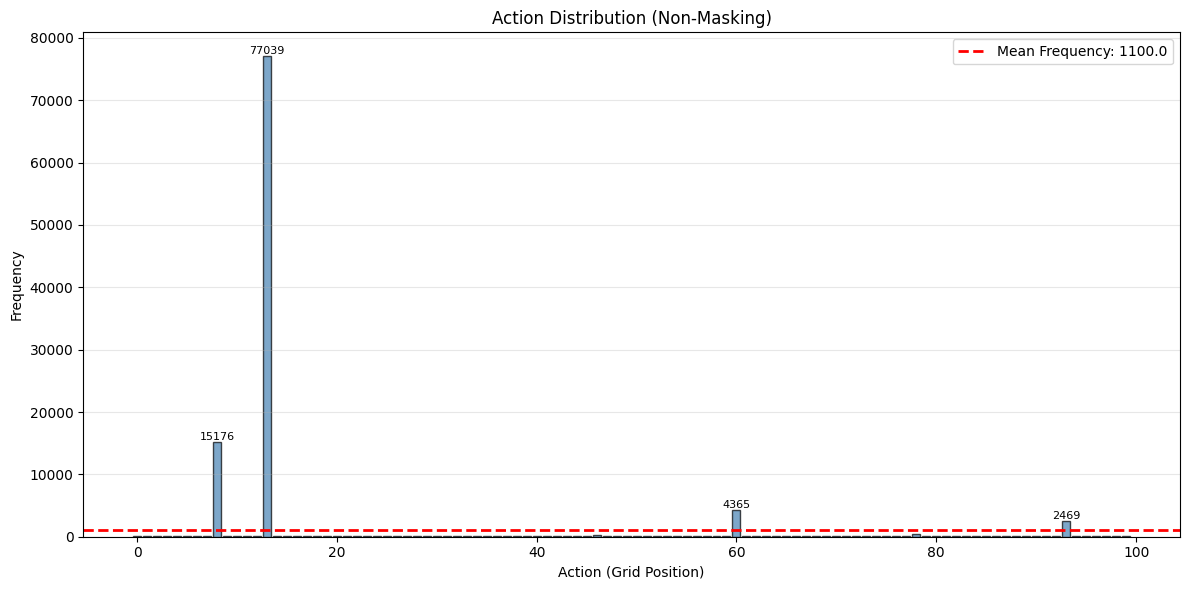

-----------------------------
Model 3 results: 
Action masking results (1000 games):
{'num_wins': 1000, 'num_lost': 0, 'num_hits': 17000, 'num_misses': 78116, 'average-hit-to-miss-ratio': 0.21762507040811102, 'win_rate': 1.0, 'avg_steps': 95.116, 'avg_reward': 304.6867999995522, 'action_distribution_samples': [{13: 1, 8: 1, 70: 1, 60: 1, 93: 1, 46: 1, 9: 1, 1: 1, 23: 1, 78: 1, 43: 1, 36: 1, 3: 1, 27: 1, 88: 1, 84: 1, 73: 1, 96: 1, 58: 1, 11: 1, 86: 1, 0: 1, 50: 1, 21: 1, 47: 1, 99: 1, 19: 1, 87: 1, 40: 1, 5: 1, 68: 1, 17: 1, 37: 1, 67: 1, 77: 1, 49: 1, 33: 1, 16: 1, 62: 1, 51: 1, 39: 1, 32: 1, 35: 1, 69: 1, 91: 1, 63: 1, 28: 1, 72: 1, 52: 1, 59: 1, 95: 1, 64: 1, 56: 1, 74: 1, 83: 1, 38: 1, 94: 1, 53: 1, 48: 1, 42: 1, 98: 1, 75: 1, 20: 1, 79: 1, 18: 1, 15: 1, 34: 1, 54: 1, 82: 1, 41: 1, 80: 1, 44: 1, 29: 1, 66: 1, 6: 1, 25: 1, 55: 1, 22: 1, 92: 1, 57: 1, 31: 1, 12: 1, 81: 1, 45: 1, 71: 1, 10: 1, 30: 1, 76: 1, 26: 1, 24: 1, 65: 1, 90: 1, 14: 1, 7: 1, 97: 1, 2: 1}, {13: 1, 8: 1, 70: 1, 60

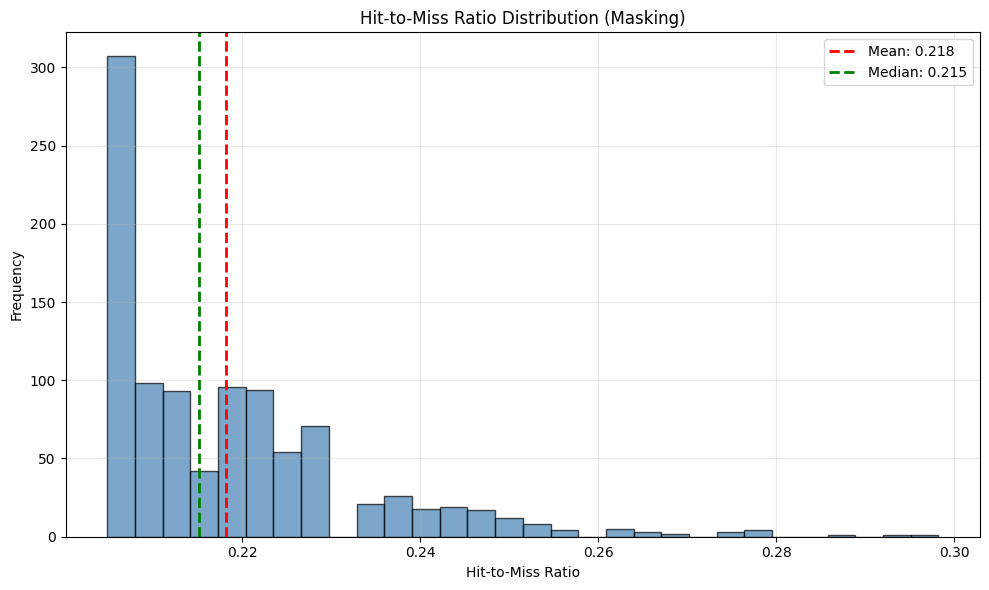

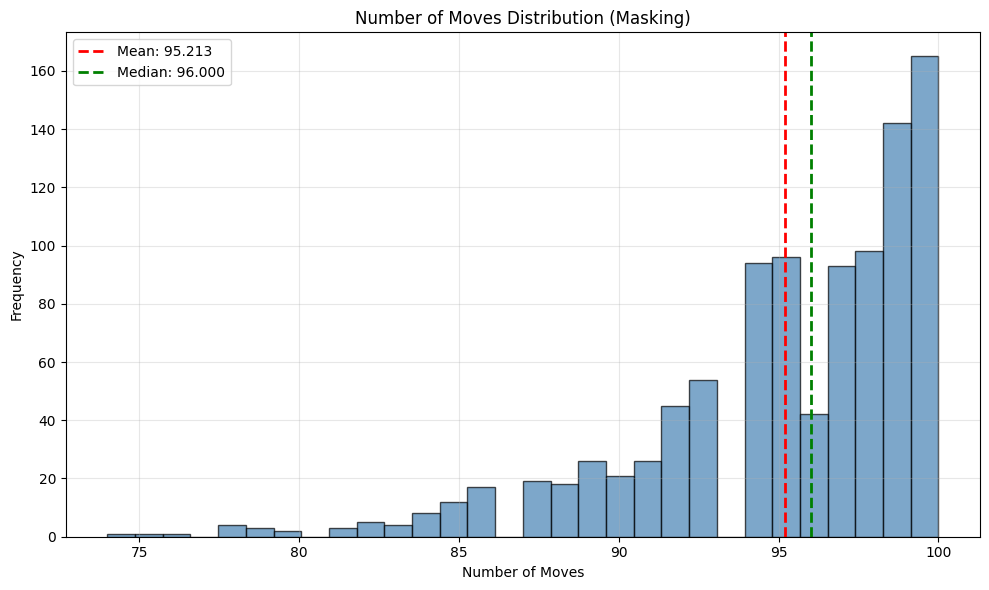

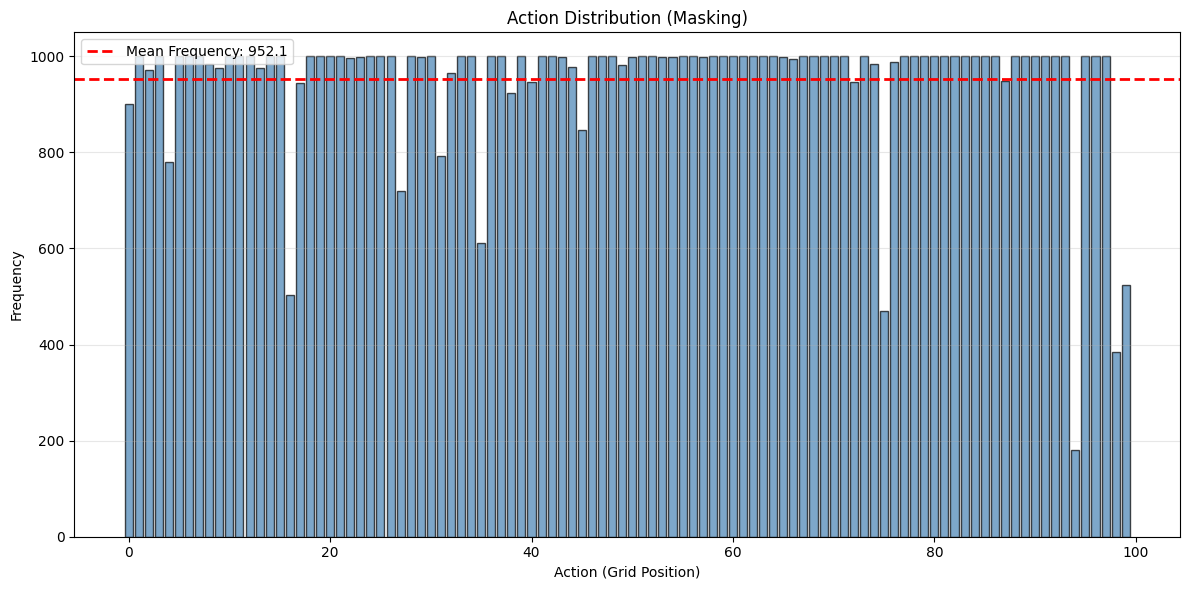

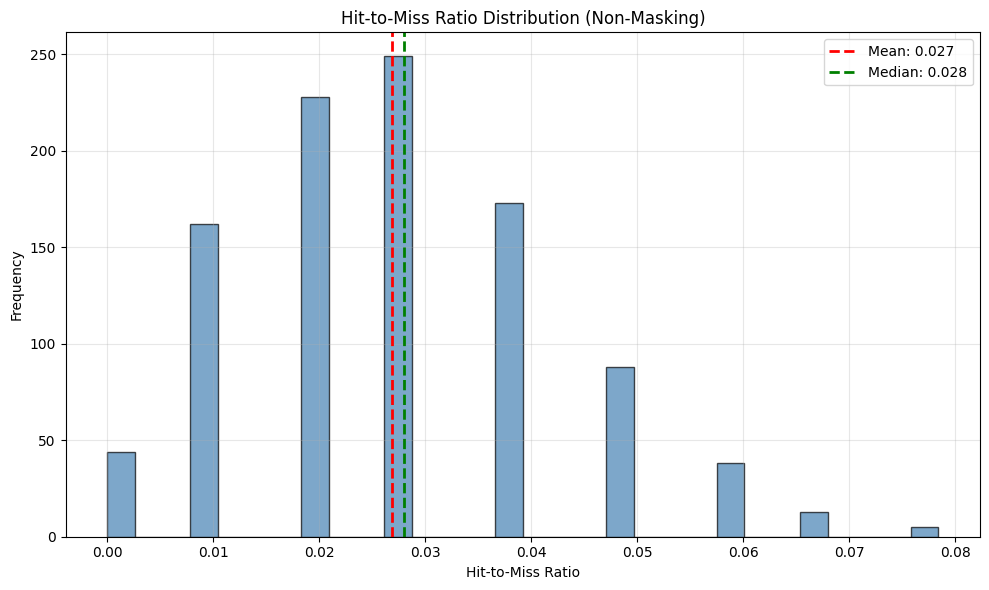

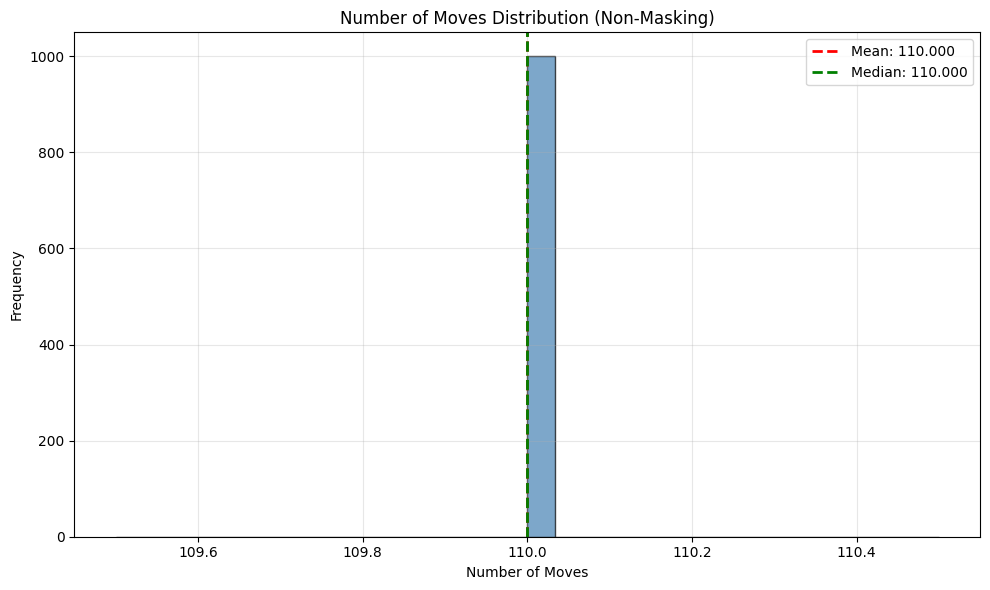

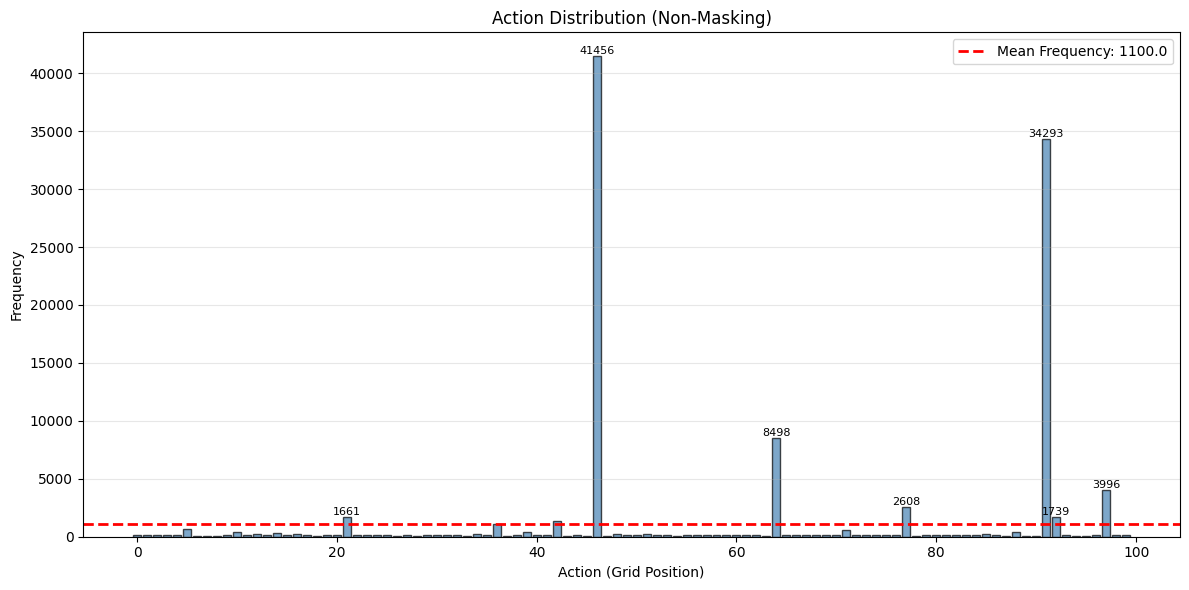

-----------------------------
Model 4 results: 
Action masking results (1000 games):
{'num_wins': 1000, 'num_lost': 0, 'num_hits': 17000, 'num_misses': 78213, 'average-hit-to-miss-ratio': 0.21735517113523328, 'win_rate': 1.0, 'avg_steps': 95.213, 'avg_reward': 300.5573999995544, 'action_distribution_samples': [{46: 1, 64: 1, 36: 1, 91: 1, 92: 1, 71: 1, 48: 1, 88: 1, 77: 1, 14: 1, 97: 1, 42: 1, 34: 1, 21: 1, 10: 1, 5: 1, 73: 1, 82: 1, 93: 1, 39: 1, 12: 1, 26: 1, 68: 1, 55: 1, 67: 1, 28: 1, 51: 1, 59: 1, 11: 1, 76: 1, 47: 1, 89: 1, 30: 1, 41: 1, 58: 1, 54: 1, 20: 1, 78: 1, 79: 1, 25: 1, 22: 1, 29: 1, 18: 1, 84: 1, 7: 1, 83: 1, 19: 1, 49: 1, 43: 1, 15: 1, 90: 1, 33: 1, 62: 1, 63: 1, 95: 1, 66: 1, 61: 1, 52: 1, 60: 1, 6: 1, 96: 1, 81: 1, 70: 1, 85: 1, 1: 1, 37: 1, 80: 1, 3: 1, 56: 1, 24: 1, 69: 1, 50: 1, 57: 1, 86: 1, 23: 1, 53: 1, 65: 1, 8: 1, 74: 1, 13: 1, 44: 1, 32: 1, 87: 1, 9: 1, 17: 1, 72: 1, 2: 1, 40: 1, 38: 1, 0: 1, 45: 1, 31: 1, 4: 1, 27: 1, 35: 1, 99: 1, 75: 1, 98: 1, 16: 1}, {46

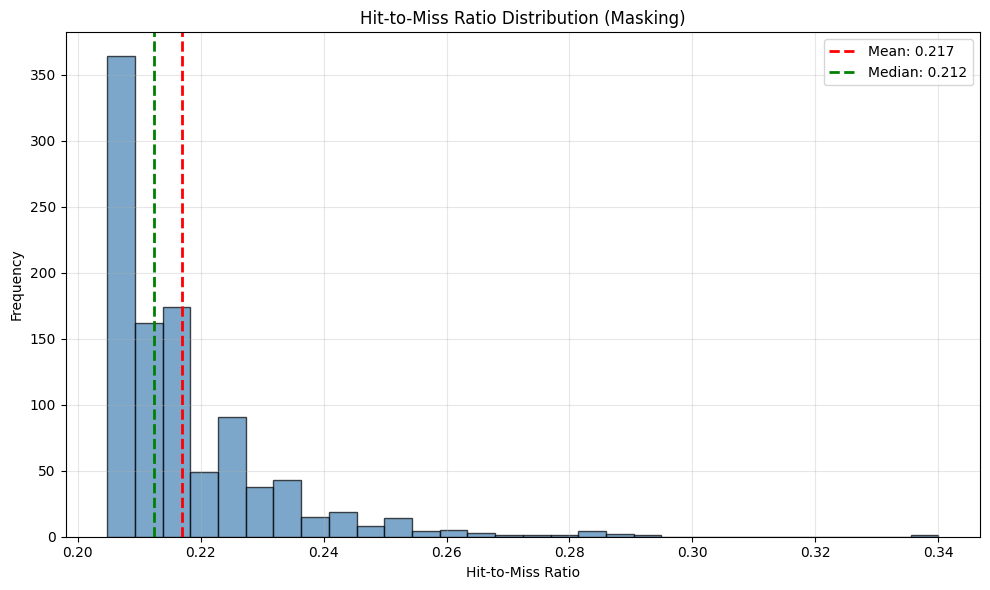

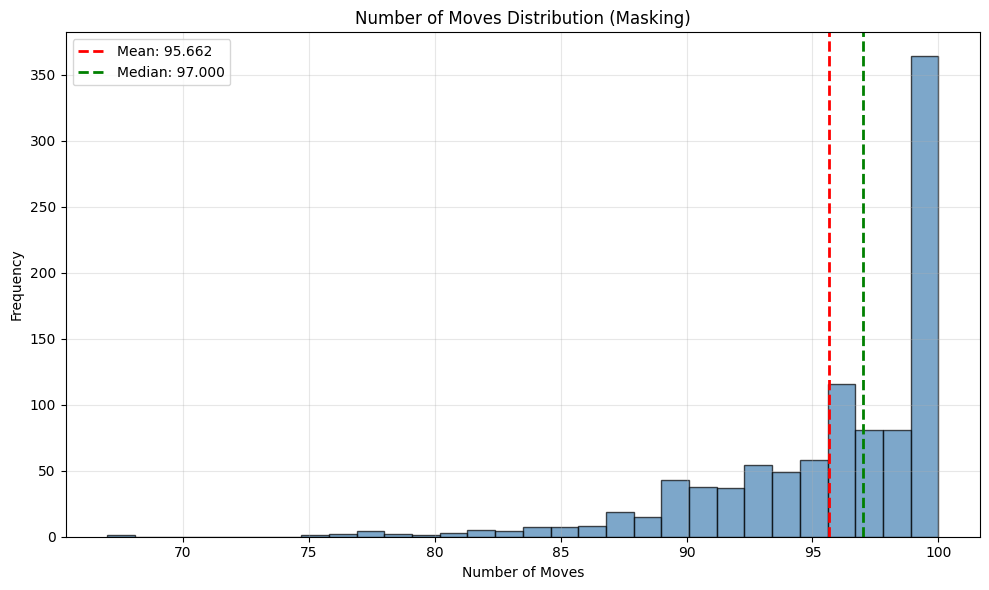

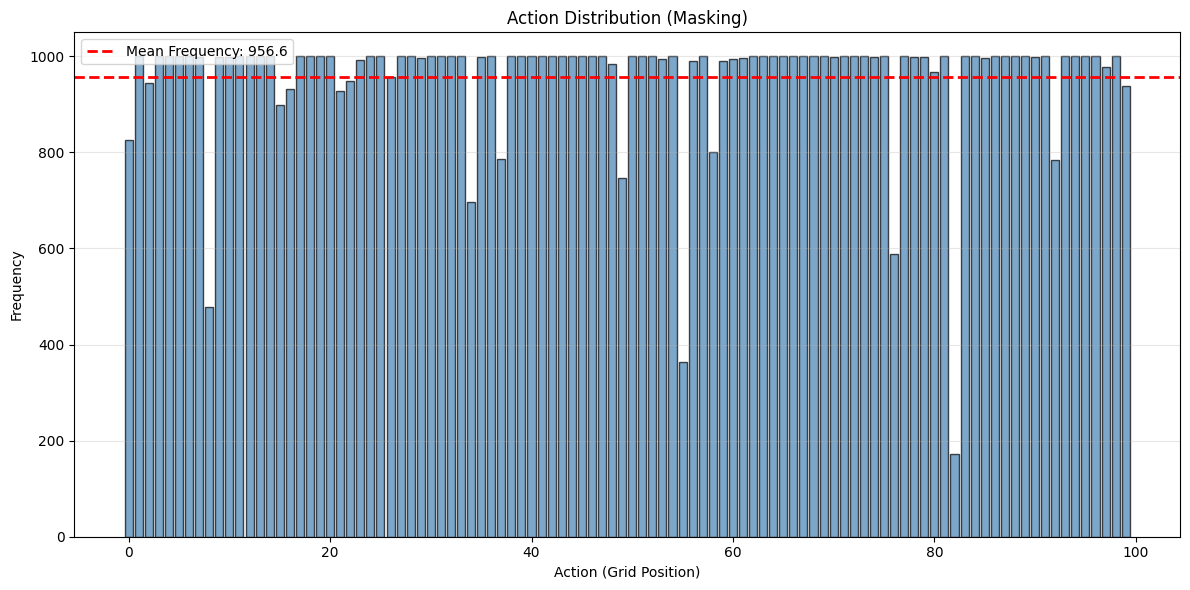

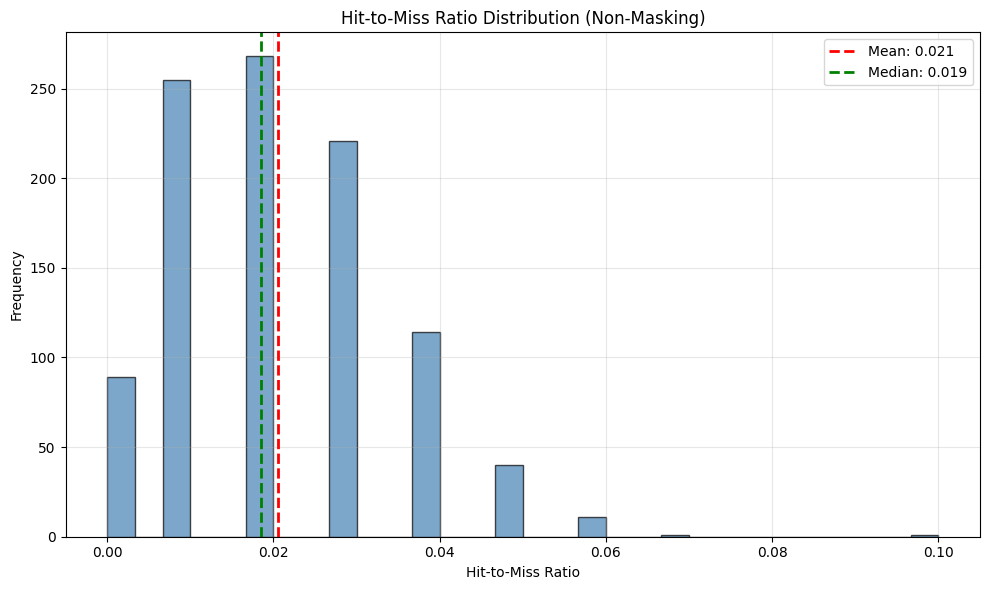

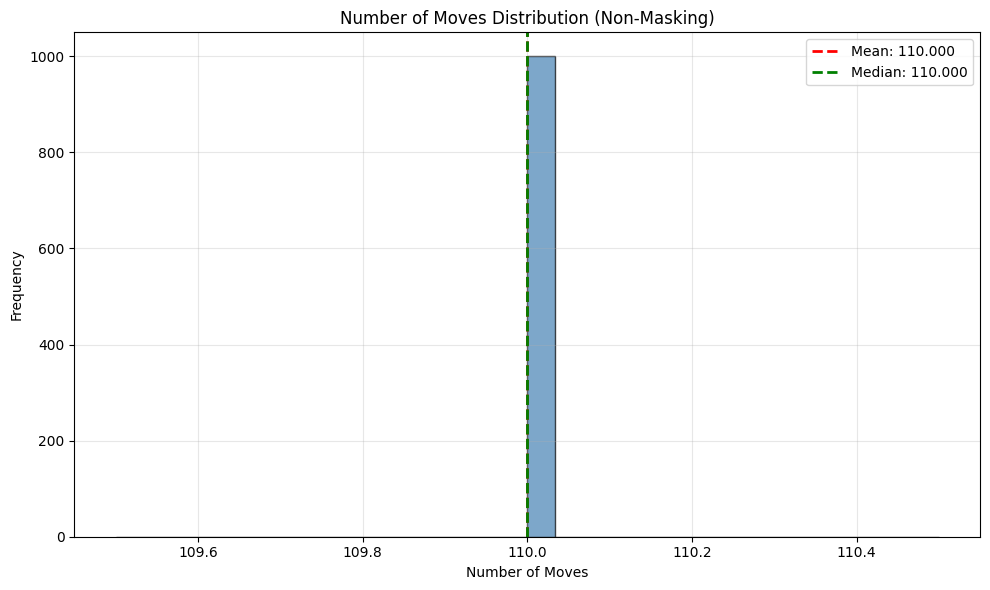

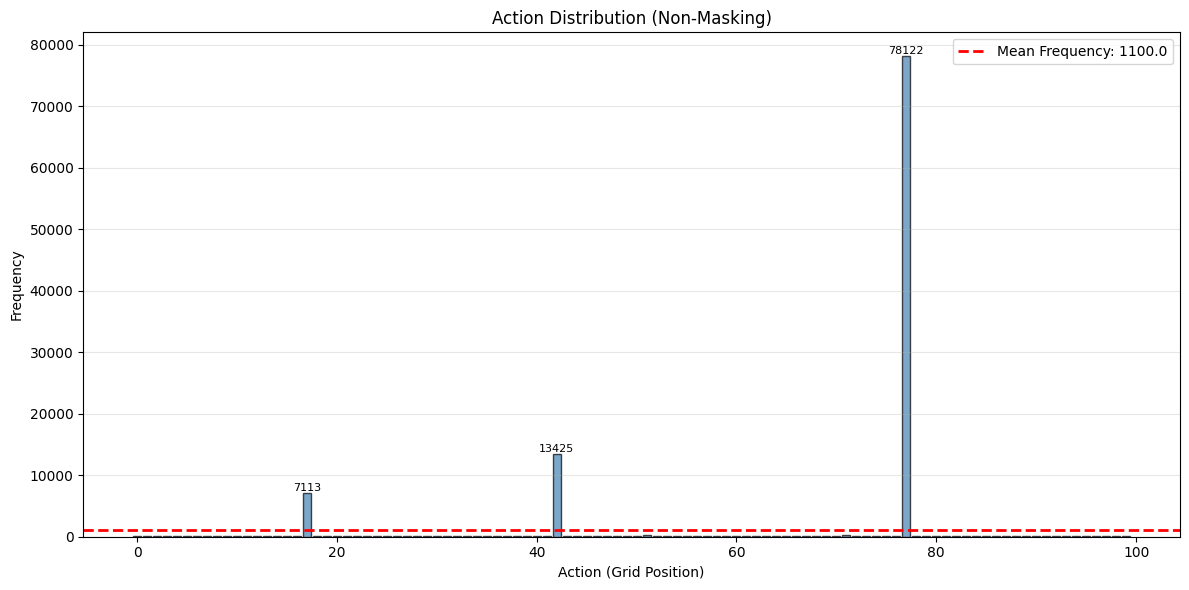

-----------------------------
Model 5 results: 
Action masking results (1000 games):
{'num_wins': 1000, 'num_lost': 0, 'num_hits': 17000, 'num_misses': 78662, 'average-hit-to-miss-ratio': 0.21611451526785488, 'win_rate': 1.0, 'avg_steps': 95.662, 'avg_reward': 303.1525999995515, 'action_distribution_samples': [{77: 1, 17: 1, 42: 1, 68: 1, 64: 1, 96: 1, 51: 1, 71: 1, 5: 1, 67: 1, 50: 1, 28: 1, 38: 1, 45: 1, 84: 1, 24: 1, 52: 1, 86: 1, 27: 1, 31: 1, 93: 1, 20: 1, 72: 1, 46: 1, 9: 1, 30: 1, 47: 1, 65: 1, 92: 1, 87: 1, 43: 1, 3: 1, 49: 1, 10: 1, 44: 1, 6: 1, 98: 1, 36: 1, 33: 1, 62: 1, 41: 1, 54: 1, 32: 1, 12: 1, 88: 1, 94: 1, 18: 1, 25: 1, 81: 1, 89: 1, 19: 1, 73: 1, 14: 1, 40: 1, 13: 1, 95: 1, 1: 1, 69: 1, 57: 1, 83: 1, 4: 1, 75: 1, 63: 1, 11: 1, 39: 1, 79: 1, 70: 1, 7: 1, 66: 1, 35: 1, 74: 1, 91: 1, 85: 1, 78: 1, 29: 1, 90: 1, 53: 1, 61: 1, 23: 1, 60: 1, 56: 1, 48: 1, 80: 1, 97: 1, 59: 1}, {77: 1, 17: 1, 42: 1, 68: 1, 64: 1, 51: 1, 96: 1, 71: 1, 5: 1, 67: 1, 50: 1, 28: 1, 38: 1, 45: 1, 

/Users/shayanhalder/Library/CloudStorage/OneDrive-Personal/UCI/ICS/CS 175/Project/gym-battleship/venv/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.42GB > 1.45GB
  warnings.warn(


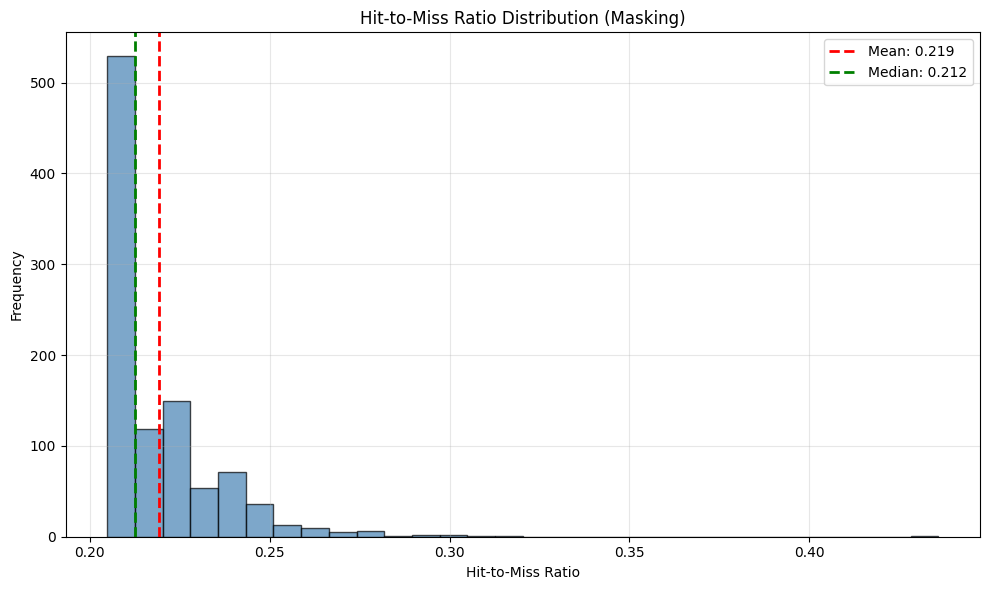

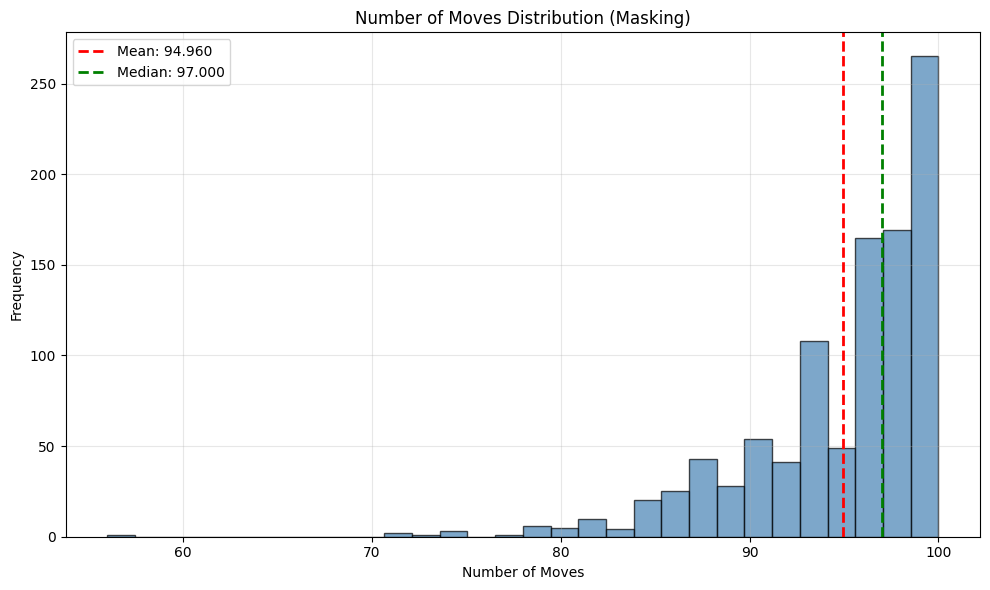

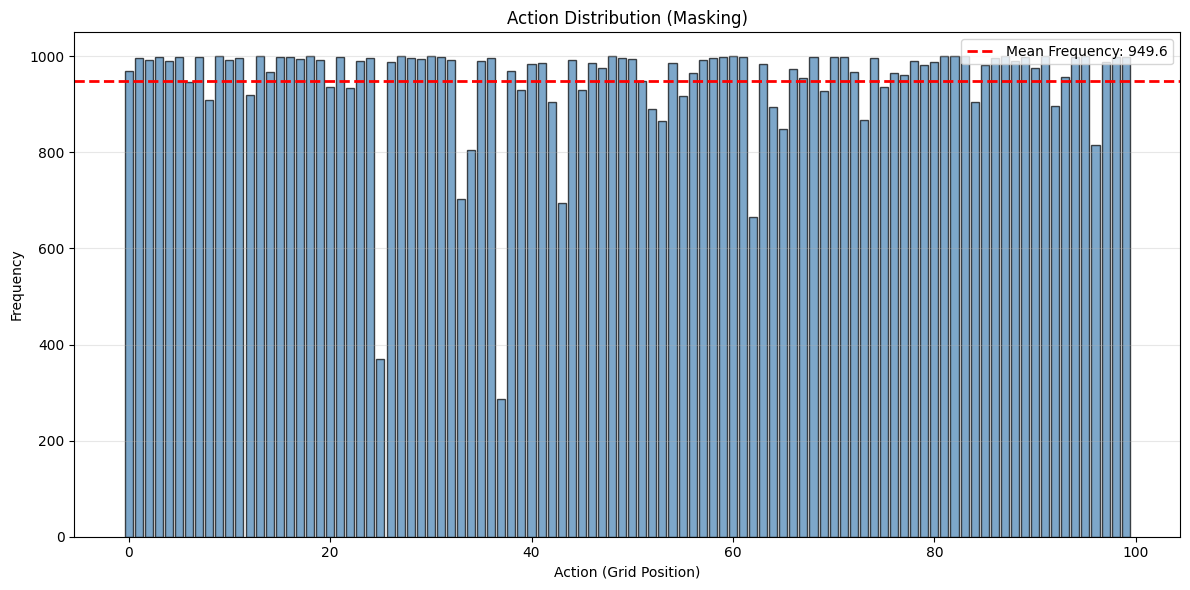

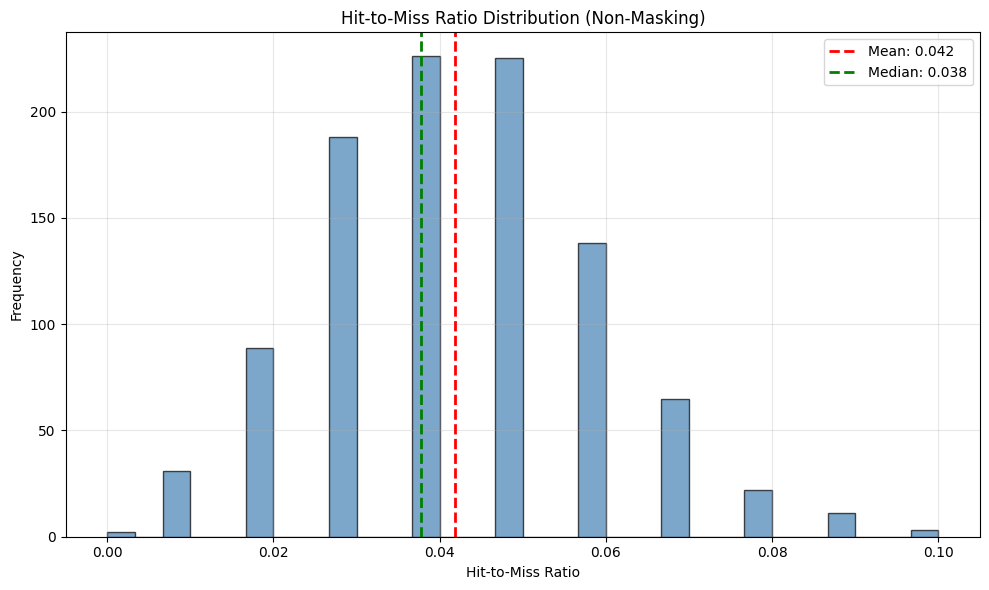

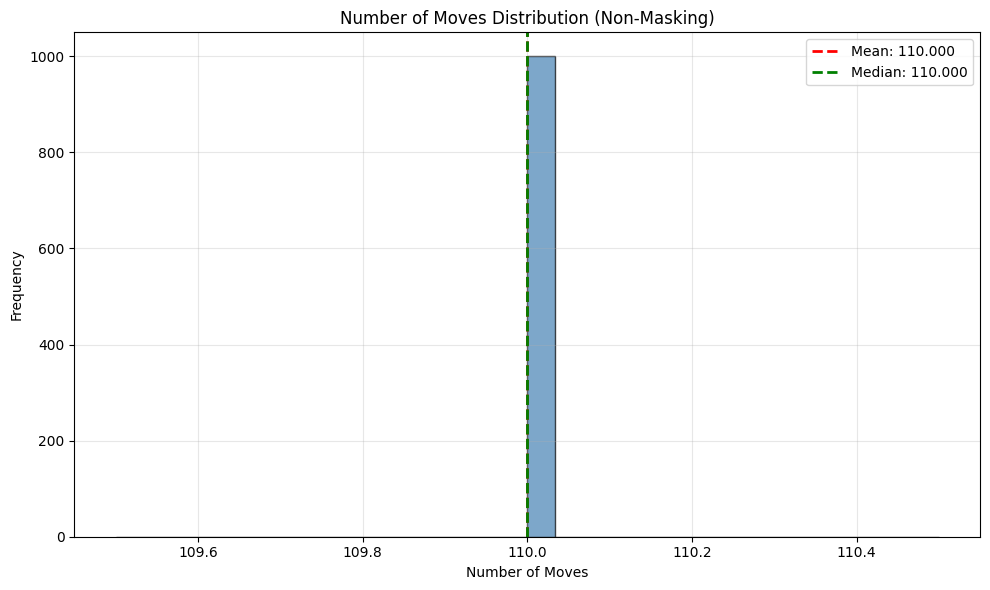

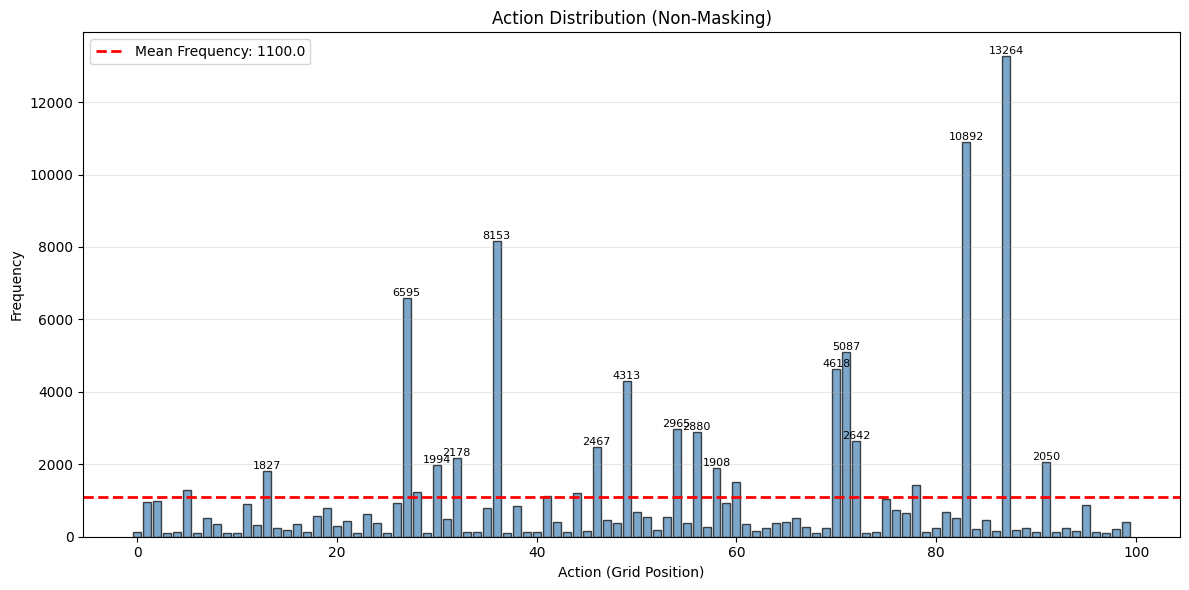

-----------------------------
Model 6 results: 
Action masking results (1000 games):
{'num_wins': 1000, 'num_lost': 0, 'num_hits': 17000, 'num_misses': 77960, 'average-hit-to-miss-ratio': 0.2180605438686506, 'win_rate': 1.0, 'avg_steps': 94.96, 'avg_reward': 303.59299999955533, 'action_distribution_samples': [{13: 1, 11: 1, 19: 1, 70: 1, 87: 1, 36: 1, 50: 1, 58: 1, 77: 1, 1: 1, 5: 1, 83: 1, 46: 1, 91: 1, 26: 1, 72: 1, 99: 1, 56: 1, 49: 1, 54: 1, 42: 1, 23: 1, 2: 1, 41: 1, 81: 1, 63: 1, 30: 1, 16: 1, 24: 1, 95: 1, 44: 1, 78: 1, 82: 1, 12: 1, 59: 1, 18: 1, 7: 1, 89: 1, 80: 1, 65: 1, 40: 1, 67: 1, 85: 1, 60: 1, 22: 1, 28: 1, 21: 1, 66: 1, 31: 1, 34: 1, 15: 1, 74: 1, 20: 1, 79: 1, 9: 1, 61: 1, 94: 1, 38: 1, 97: 1, 3: 1, 57: 1, 0: 1, 88: 1, 71: 1, 48: 1, 27: 1, 4: 1, 10: 1, 29: 1, 98: 1, 14: 1, 32: 1, 93: 1, 68: 1, 45: 1, 39: 1, 35: 1, 6: 1, 73: 1, 64: 1, 92: 1, 75: 1, 17: 1, 51: 1, 90: 1, 76: 1, 86: 1, 47: 1, 55: 1, 33: 1, 84: 1, 52: 1, 69: 1, 96: 1, 53: 1, 8: 1, 43: 1, 25: 1}, {13: 1, 11:

/Users/shayanhalder/Library/CloudStorage/OneDrive-Personal/UCI/ICS/CS 175/Project/gym-battleship/venv/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.42GB > 1.93GB
  warnings.warn(


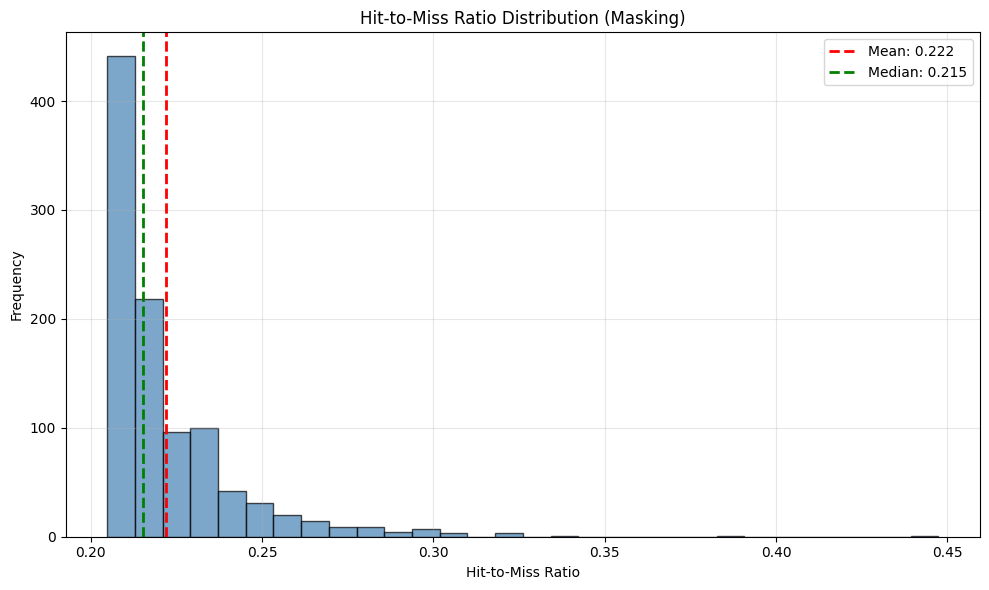

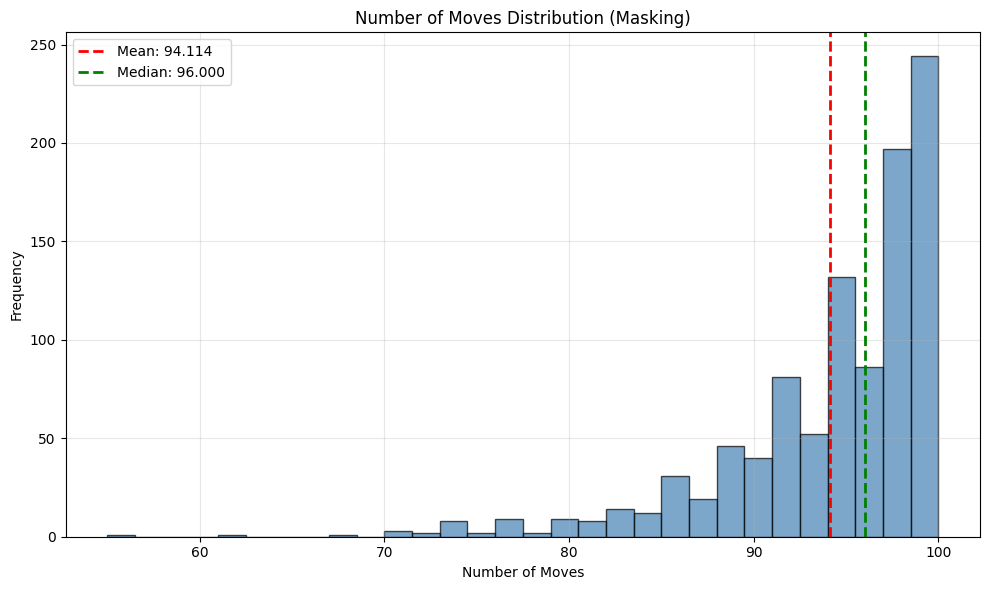

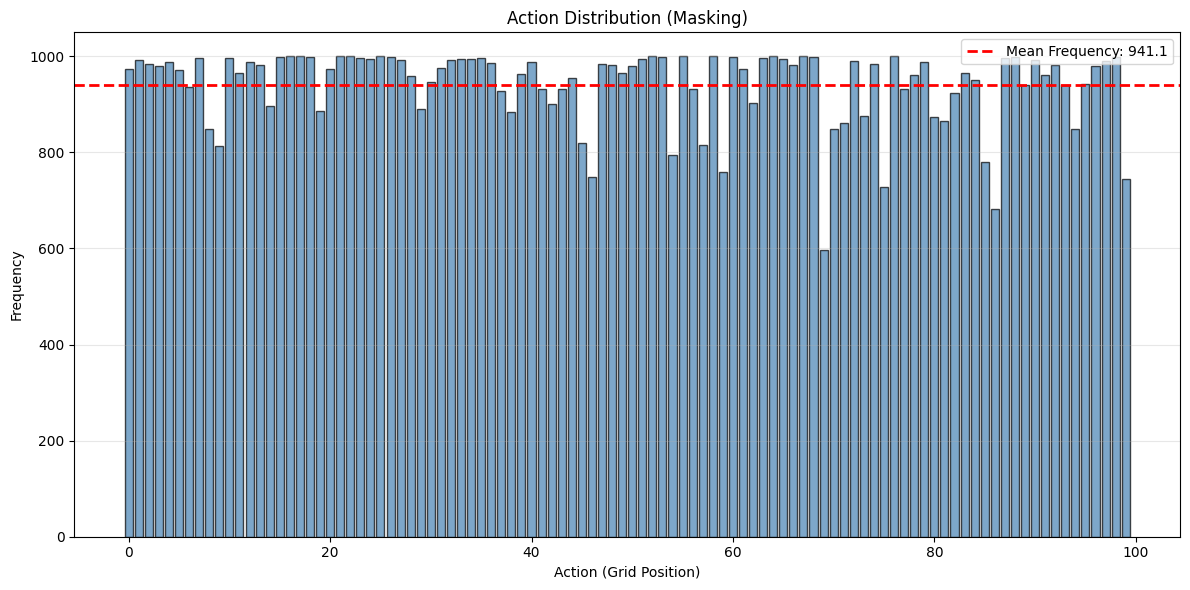

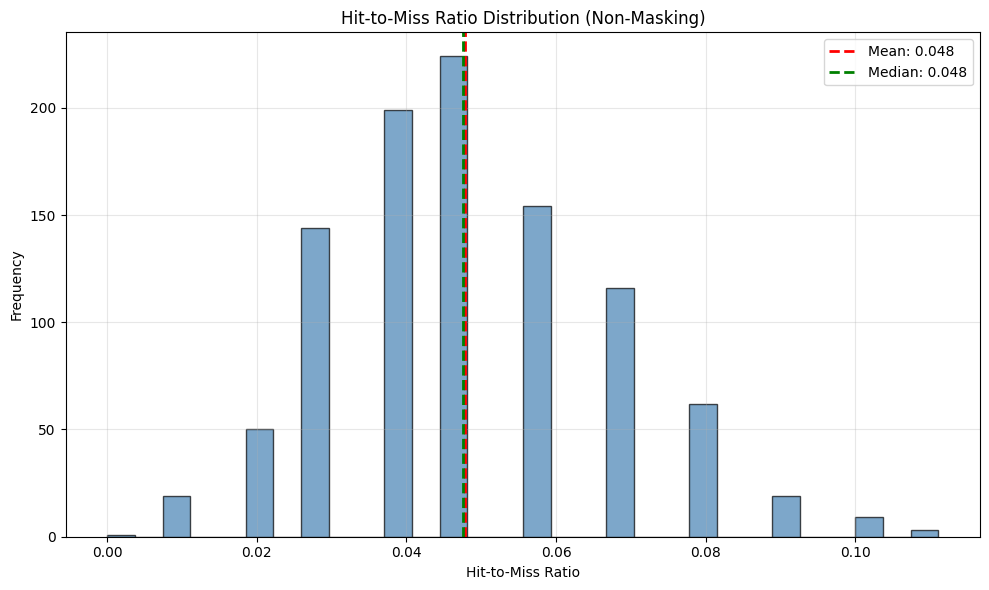

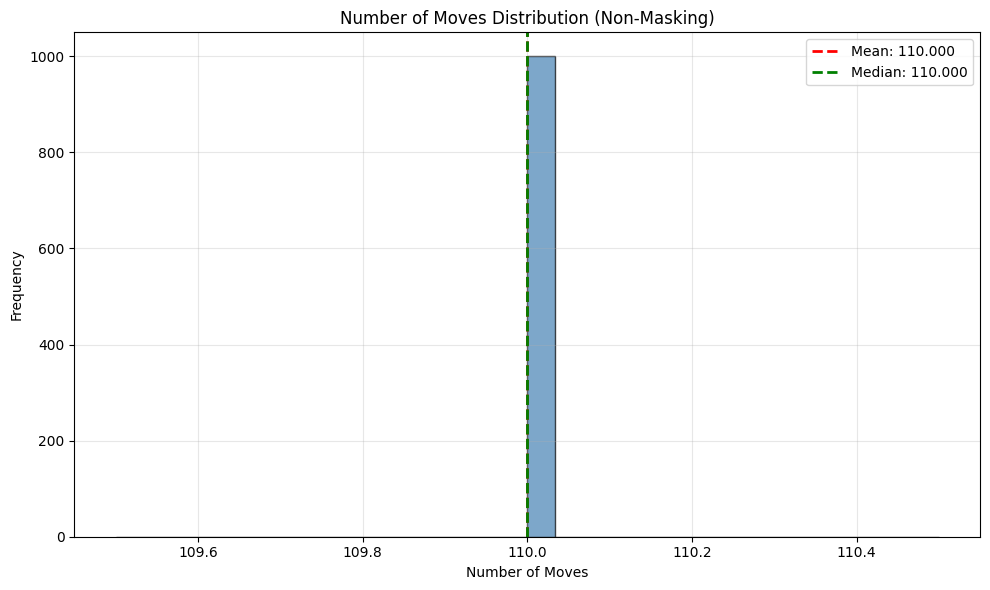

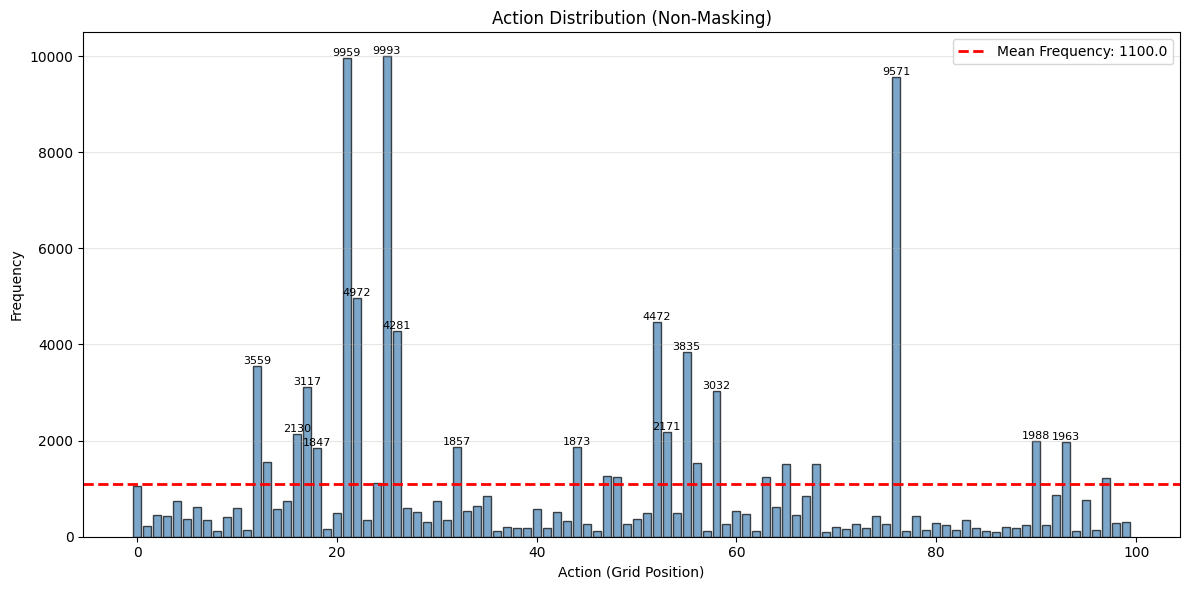

-----------------------------
Model 7 results: 
Action masking results (1000 games):
{'num_wins': 1000, 'num_lost': 0, 'num_hits': 17000, 'num_misses': 77114, 'average-hit-to-miss-ratio': 0.22045283606089686, 'win_rate': 1.0, 'avg_steps': 94.114, 'avg_reward': 304.2571999995594, 'action_distribution_samples': [{17: 1, 76: 1, 92: 1, 81: 1, 13: 1, 60: 1, 56: 1, 32: 1, 21: 1, 12: 1, 54: 1, 98: 1, 52: 1, 16: 1, 75: 1, 29: 1, 20: 1, 58: 1, 55: 1, 24: 1, 22: 1, 42: 1, 99: 1, 15: 1, 34: 1, 78: 1, 93: 1, 23: 1, 66: 1, 57: 1, 63: 1, 27: 1, 68: 1, 97: 1, 18: 1, 72: 1, 25: 1, 10: 1, 7: 1, 67: 1, 49: 1, 64: 1, 0: 1, 90: 1, 3: 1, 89: 1, 96: 1, 5: 1, 79: 1, 74: 1, 39: 1, 8: 1, 26: 1, 83: 1, 87: 1, 36: 1, 43: 1, 61: 1, 30: 1, 38: 1, 88: 1, 37: 1, 53: 1, 1: 1, 11: 1, 71: 1, 65: 1, 33: 1, 44: 1, 84: 1, 50: 1, 91: 1, 31: 1, 73: 1, 70: 1, 47: 1, 14: 1, 28: 1, 2: 1, 19: 1, 62: 1, 41: 1, 46: 1, 4: 1, 9: 1, 6: 1, 95: 1, 40: 1, 35: 1, 86: 1, 82: 1, 45: 1, 94: 1, 51: 1, 80: 1, 77: 1}, {17: 1, 76: 1, 26: 1, 92

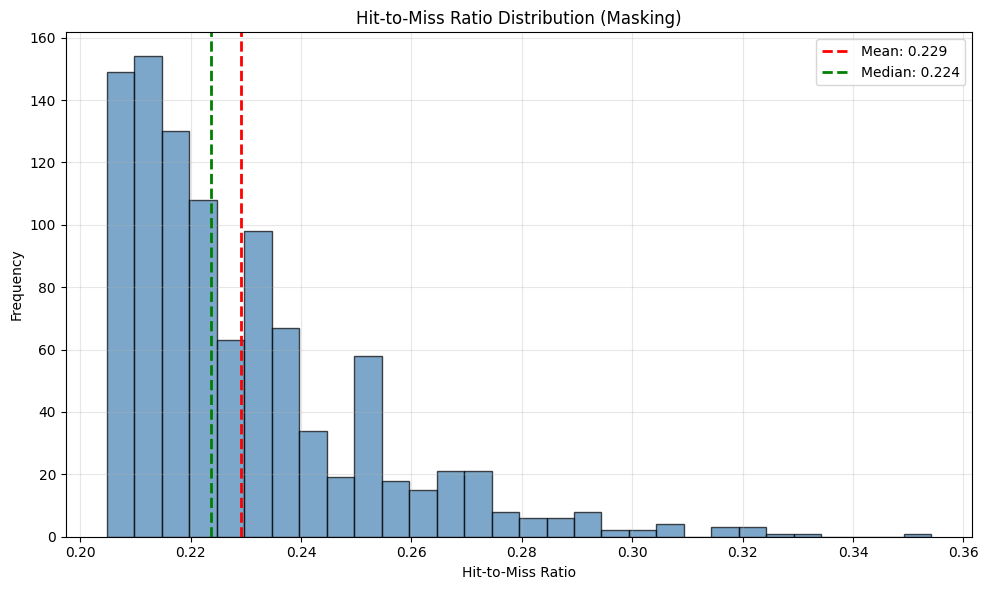

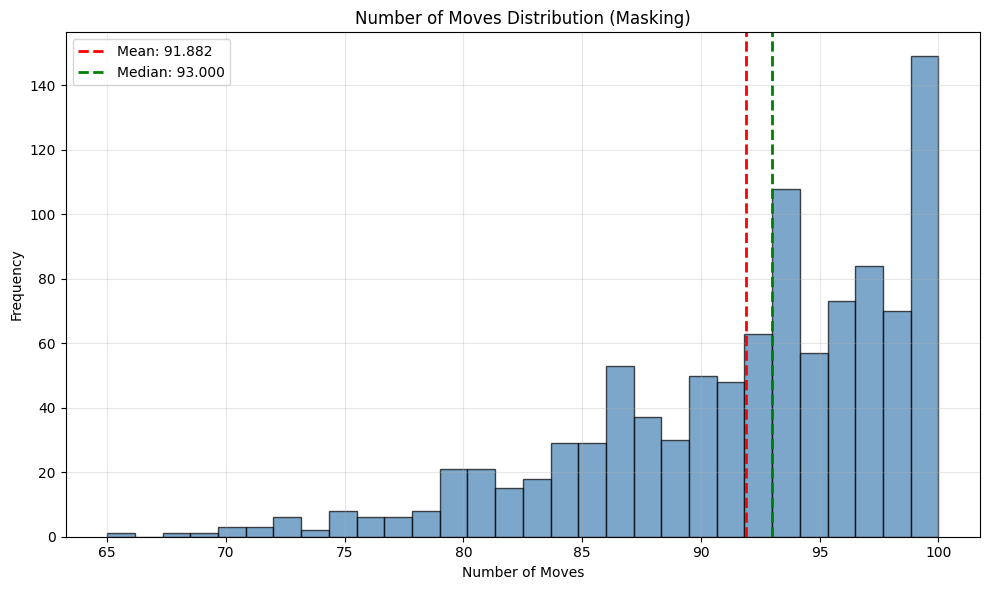

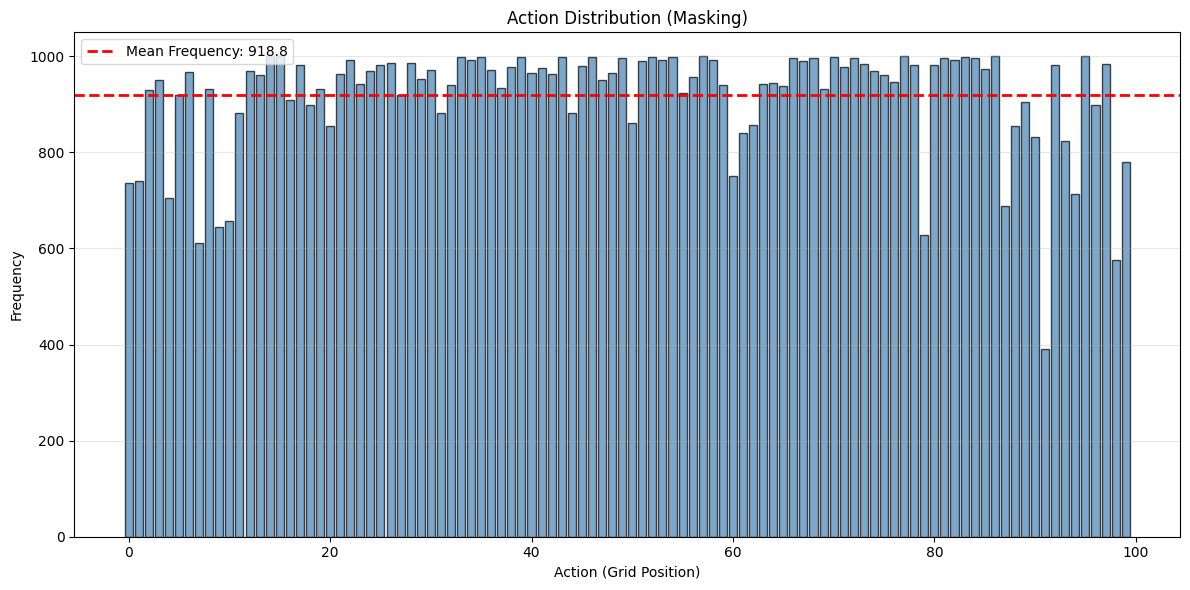

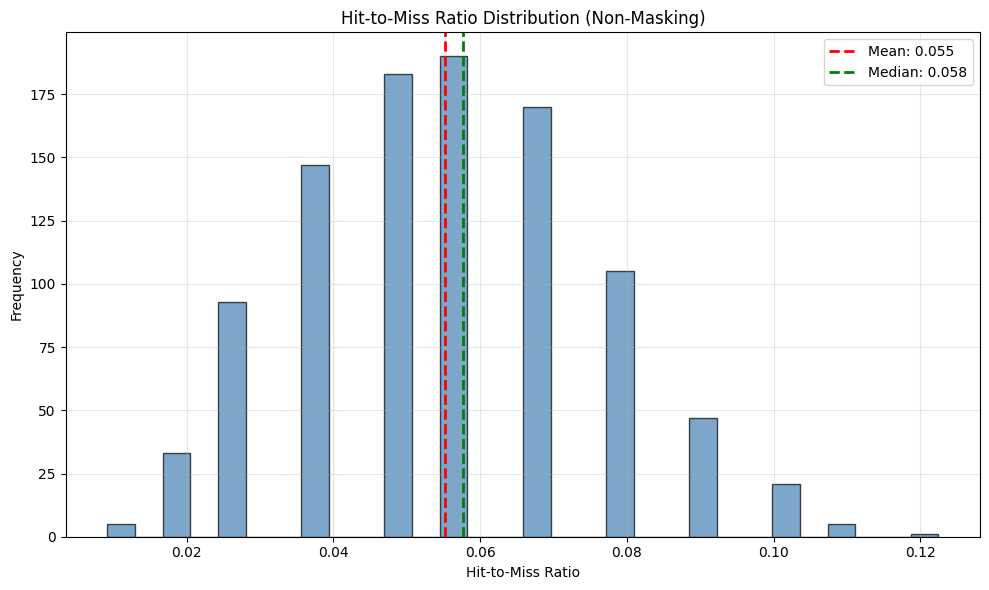

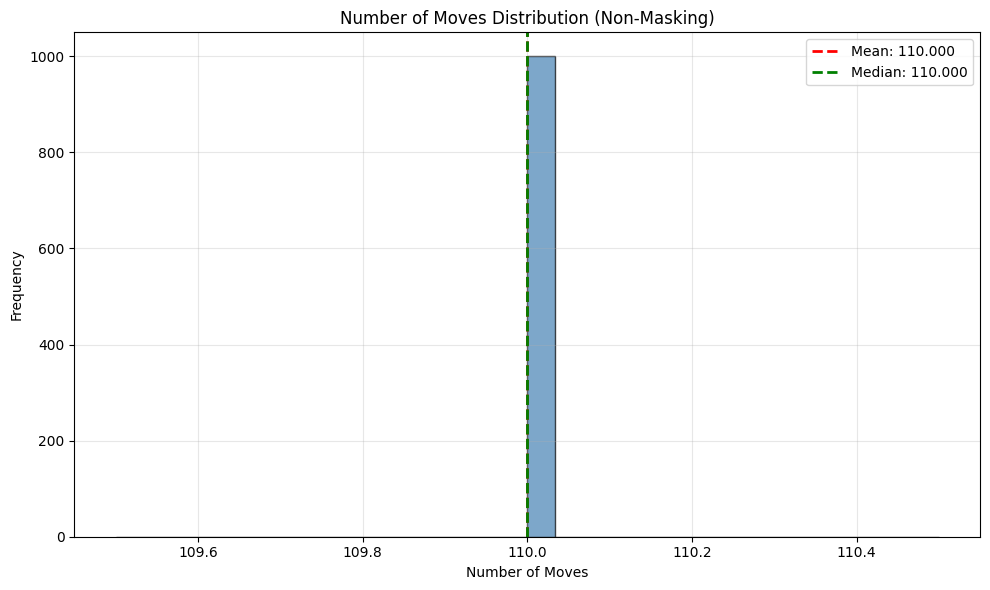

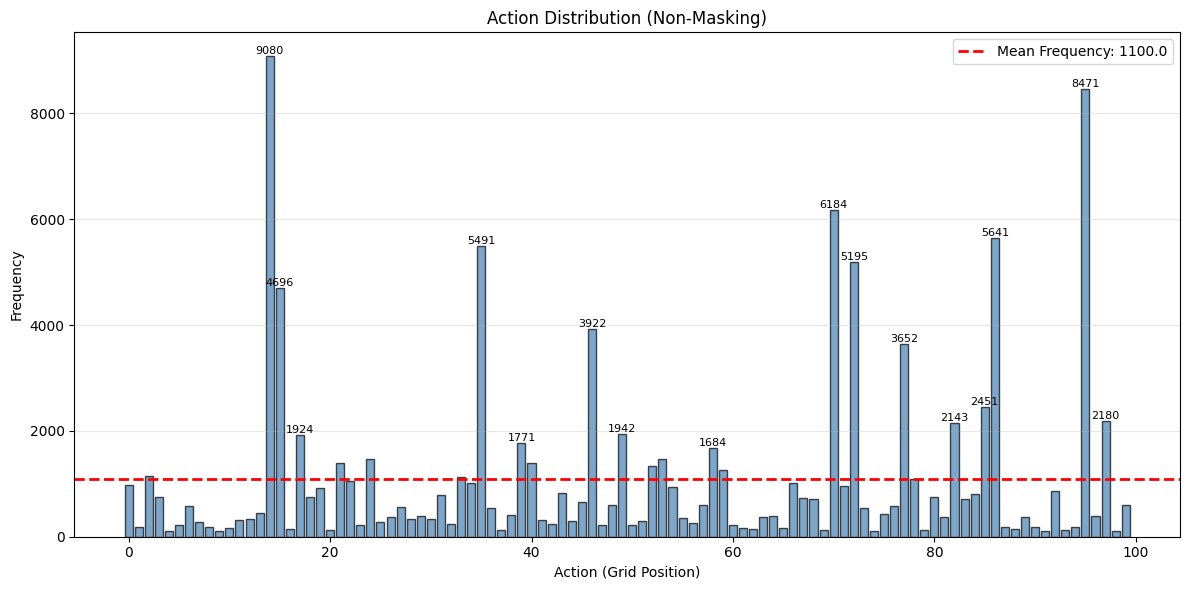

-----------------------------
Model 8 results: 
Action masking results (1000 games):
{'num_wins': 1000, 'num_lost': 0, 'num_hits': 17000, 'num_misses': 74882, 'average-hit-to-miss-ratio': 0.22702385085868432, 'win_rate': 1.0, 'avg_steps': 91.882, 'avg_reward': 305.55859999956965, 'action_distribution_samples': [{77: 1, 95: 1, 43: 1, 86: 1, 6: 1, 96: 1, 53: 1, 35: 1, 85: 1, 76: 1, 22: 1, 72: 1, 0: 1, 94: 1, 68: 1, 18: 1, 15: 1, 34: 1, 21: 1, 49: 1, 37: 1, 14: 1, 41: 1, 92: 1, 13: 1, 70: 1, 24: 1, 33: 1, 54: 1, 30: 1, 38: 1, 63: 1, 17: 1, 46: 1, 80: 1, 78: 1, 29: 1, 31: 1, 39: 1, 71: 1, 58: 1, 23: 1, 8: 1, 64: 1, 32: 1, 57: 1, 82: 1, 25: 1, 84: 1, 55: 1, 97: 1, 51: 1, 66: 1, 60: 1, 67: 1, 89: 1, 52: 1, 83: 1, 28: 1, 56: 1, 88: 1, 74: 1, 81: 1, 40: 1, 73: 1, 45: 1, 19: 1, 42: 1, 48: 1, 75: 1, 20: 1, 12: 1, 3: 1, 16: 1, 90: 1, 65: 1, 69: 1, 27: 1, 36: 1, 26: 1, 47: 1, 61: 1, 87: 1, 59: 1, 5: 1, 62: 1, 50: 1, 9: 1, 93: 1, 10: 1, 2: 1, 4: 1, 1: 1, 91: 1, 11: 1, 44: 1}, {77: 1, 95: 1, 39: 1, 

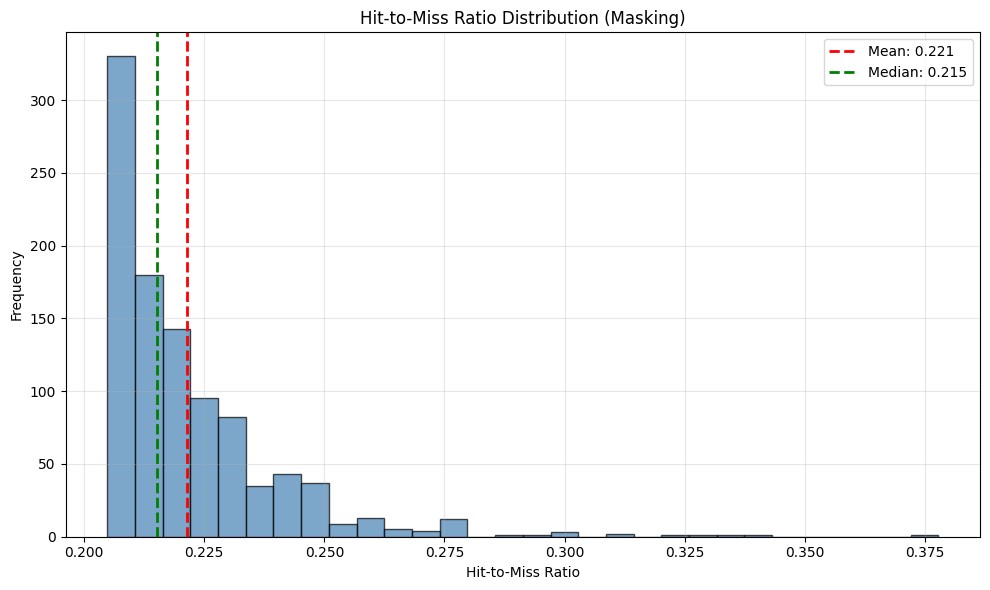

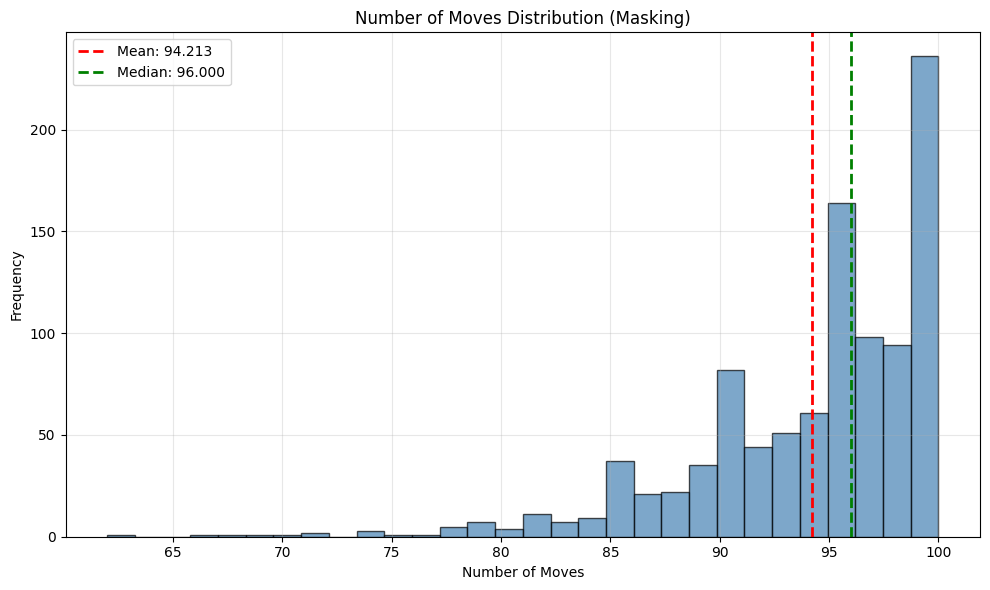

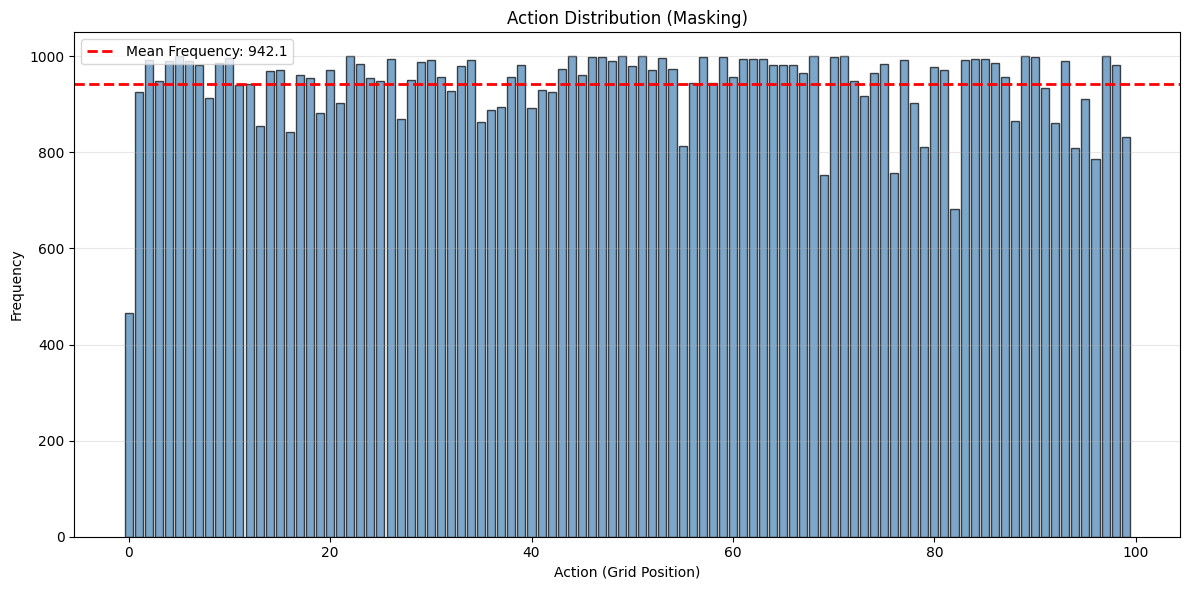

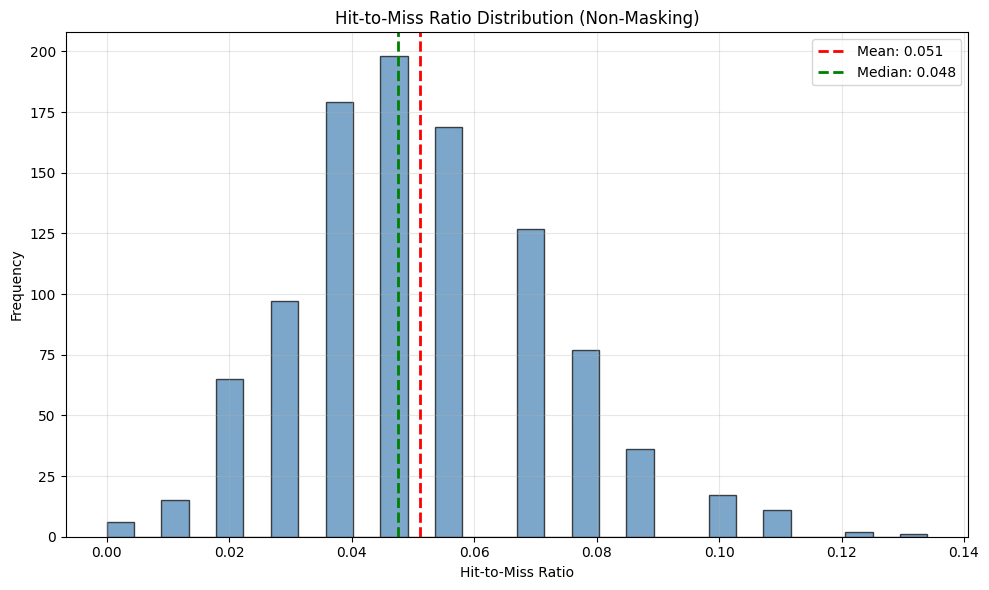

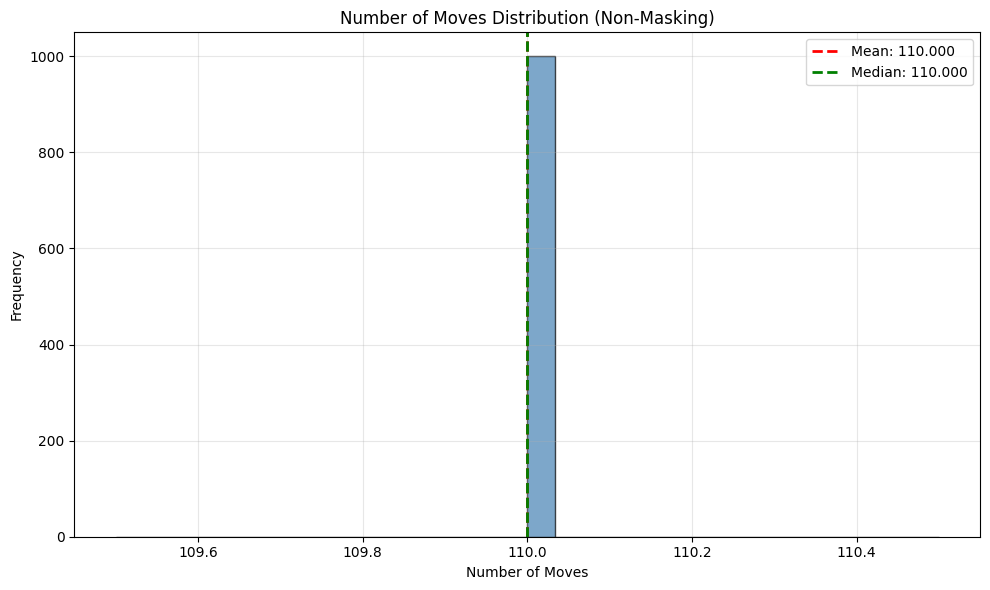

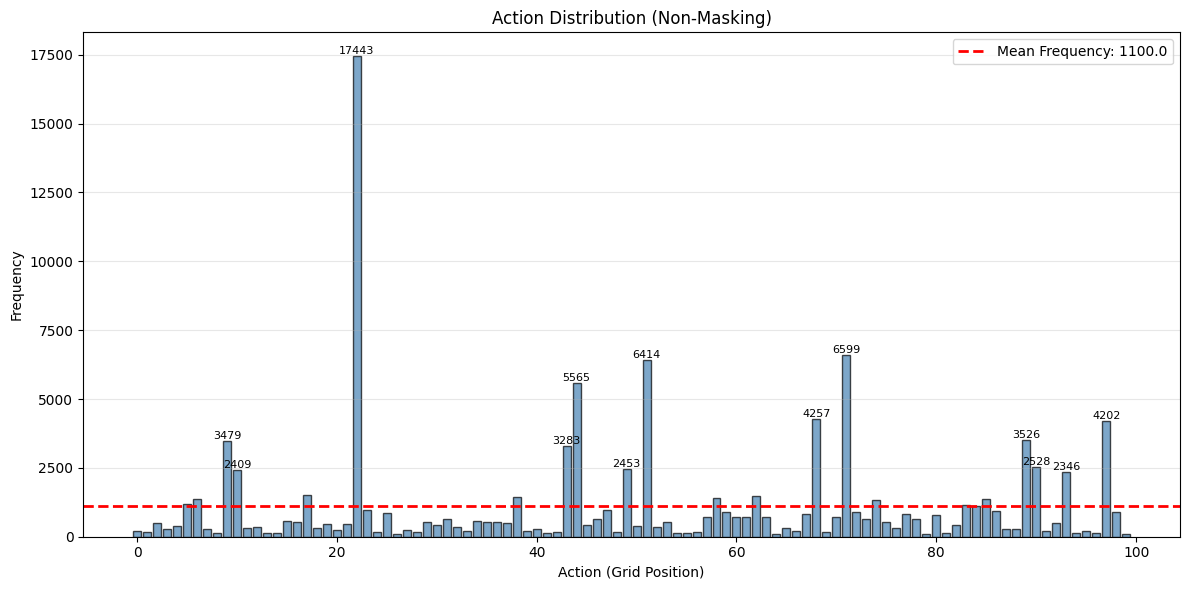

-----------------------------
Model 9 results: 
Action masking results (1000 games):
{'num_wins': 1000, 'num_lost': 0, 'num_hits': 17000, 'num_misses': 77213, 'average-hit-to-miss-ratio': 0.2201701785968684, 'win_rate': 1.0, 'avg_steps': 94.213, 'avg_reward': 304.7023999995556, 'action_distribution_samples': [{44: 1, 22: 1, 89: 1, 90: 1, 51: 1, 71: 1, 97: 1, 6: 1, 62: 1, 5: 1, 68: 1, 78: 1, 47: 1, 57: 1, 19: 1, 74: 1, 38: 1, 86: 1, 65: 1, 27: 1, 60: 1, 25: 1, 9: 1, 88: 1, 80: 1, 72: 1, 17: 1, 34: 1, 67: 1, 26: 1, 61: 1, 8: 1, 30: 1, 84: 1, 58: 1, 83: 1, 16: 1, 3: 1, 32: 1, 4: 1, 98: 1, 23: 1, 70: 1, 63: 1, 21: 1, 64: 1, 14: 1, 7: 1, 42: 1, 28: 1, 48: 1, 39: 1, 12: 1, 53: 1, 77: 1, 15: 1, 56: 1, 31: 1, 93: 1, 49: 1, 52: 1, 46: 1, 75: 1, 11: 1, 45: 1, 18: 1, 2: 1, 87: 1, 29: 1, 1: 1, 99: 1, 54: 1, 40: 1, 33: 1, 91: 1, 94: 1, 41: 1, 95: 1, 20: 1, 10: 1, 43: 1, 81: 1, 85: 1, 59: 1, 24: 1, 50: 1, 82: 1, 96: 1, 69: 1, 13: 1, 37: 1, 79: 1, 92: 1, 55: 1, 66: 1, 35: 1, 36: 1, 73: 1, 76: 1}, {44

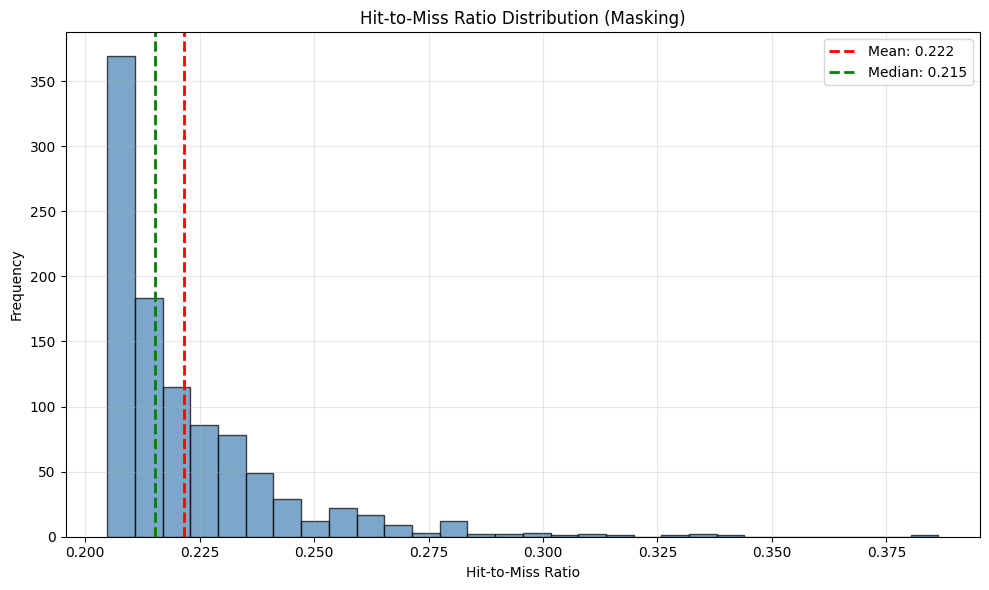

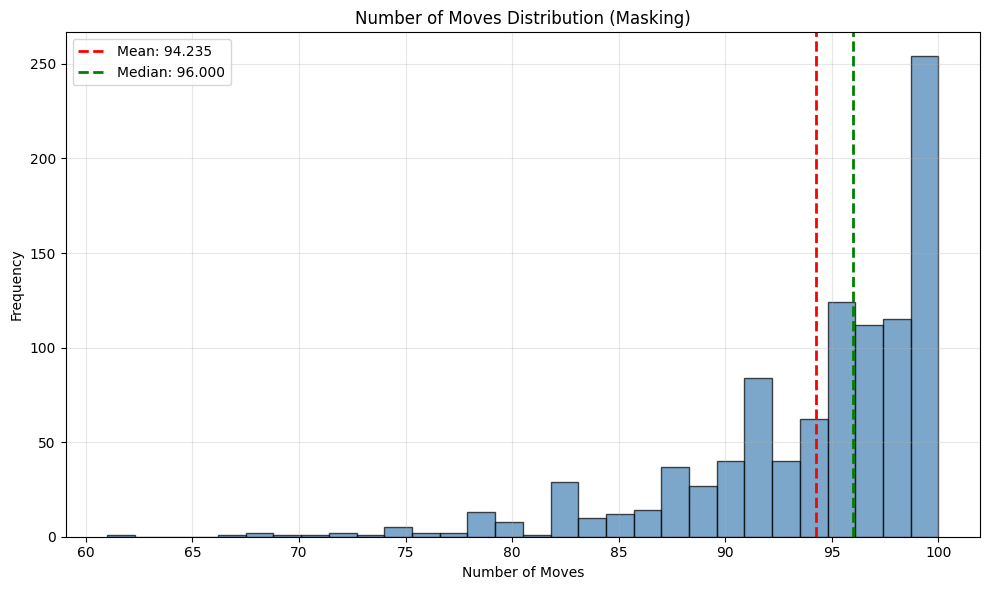

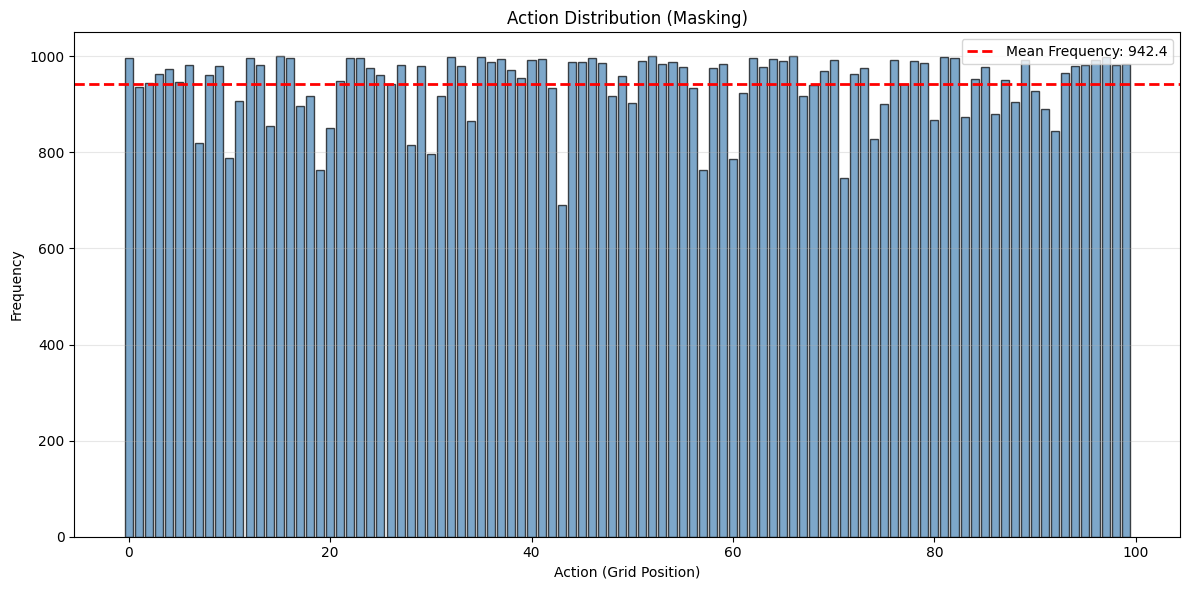

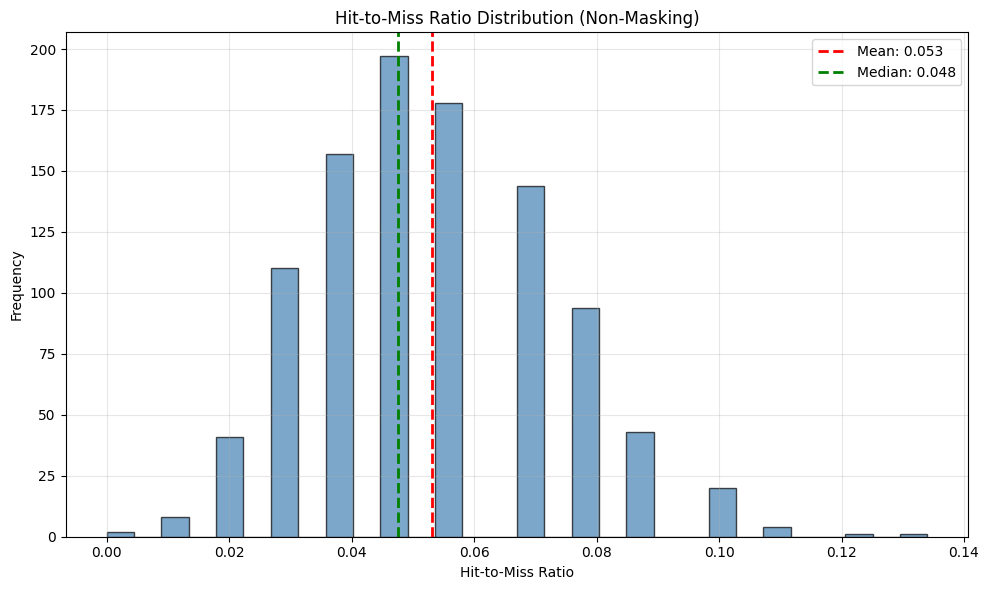

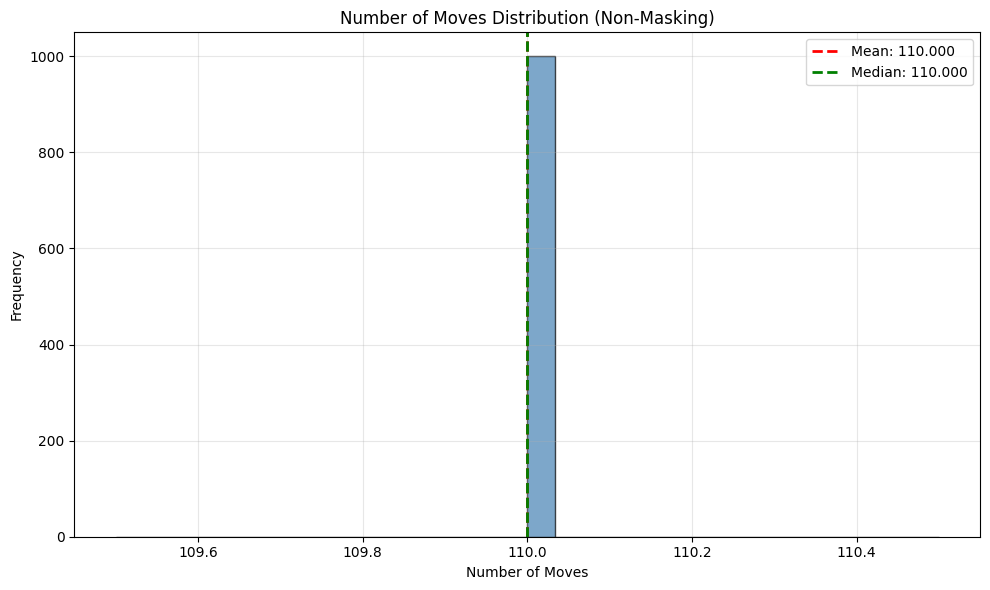

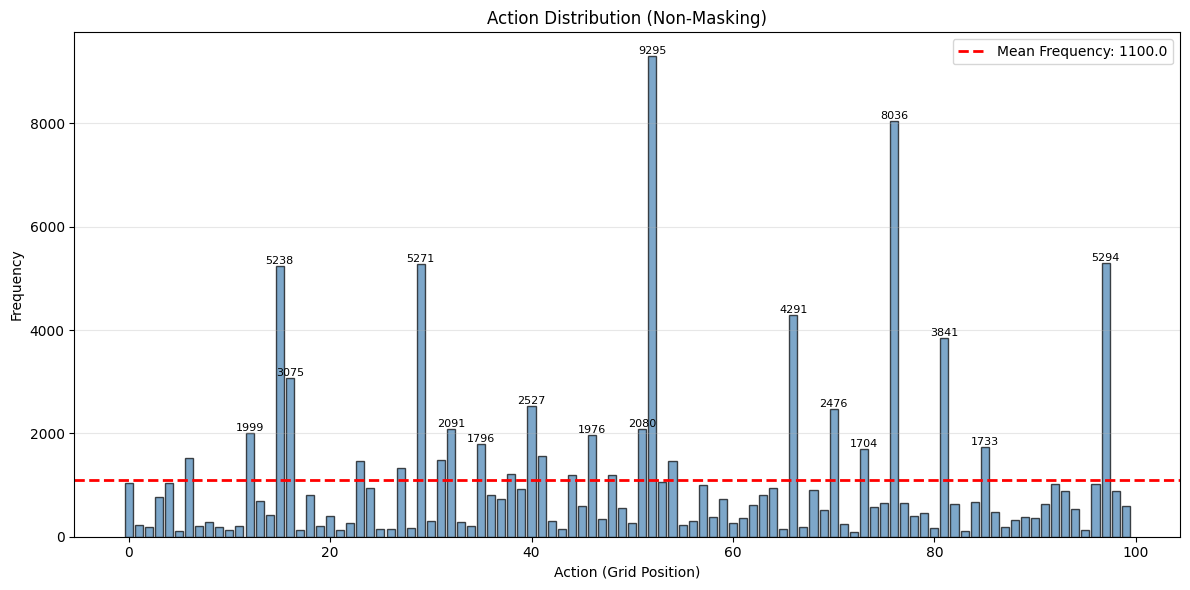

-----------------------------
Model 10 results: 
Action masking results (1000 games):
{'num_wins': 1000, 'num_lost': 0, 'num_hits': 17000, 'num_misses': 77235, 'average-hit-to-miss-ratio': 0.22010746423253708, 'win_rate': 1.0, 'avg_steps': 94.235, 'avg_reward': 304.09799999956005, 'action_distribution_samples': [{66: 1, 52: 1, 15: 1, 40: 1, 24: 1, 51: 1, 97: 1, 92: 1, 12: 1, 76: 1, 81: 1, 73: 1, 50: 1, 18: 1, 16: 1, 48: 1, 35: 1, 57: 1, 20: 1, 1: 1, 60: 1, 36: 1, 77: 1, 53: 1, 29: 1, 93: 1, 96: 1, 46: 1, 54: 1, 99: 1, 61: 1, 63: 1, 14: 1, 87: 1, 7: 1, 65: 1, 70: 1, 23: 1, 85: 1, 84: 1, 28: 1, 19: 1, 69: 1, 31: 1, 0: 1, 3: 1, 62: 1, 21: 1, 32: 1, 45: 1, 89: 1, 90: 1, 67: 1, 37: 1, 2: 1, 6: 1, 98: 1, 59: 1, 64: 1, 8: 1, 58: 1, 68: 1, 41: 1, 9: 1, 39: 1, 27: 1, 49: 1, 82: 1, 94: 1, 4: 1, 56: 1, 83: 1, 25: 1, 38: 1, 55: 1, 91: 1, 79: 1, 34: 1, 22: 1, 88: 1, 95: 1, 72: 1, 78: 1, 5: 1, 33: 1, 30: 1, 26: 1, 13: 1, 75: 1, 47: 1, 10: 1}, {66: 1, 52: 1, 15: 1, 40: 1, 24: 1, 51: 1, 97: 1, 92: 1, 

In [ ]:
models_dir = "./dqn_models"

num_models = len([f for f in os.listdir(models_dir) if f.startswith("dqn")])

for index in range(num_models): 
    model_name = f"dqn-{index + 1}"
    num_truncated = 0
    num_wins = 0
    num_steps = 0
    total_reward = 0
    
    model_path = os.path.join(models_dir, f"dqn_model_{index + 1}", model_name)
    model = DQN.load(model_path)
    NUM_GAMES = 1000
    
    # 1000 games with action masking and 1000 without action masking
    action_masking_results = run_games(model, env, num_games=NUM_GAMES, mask=True)
    non_action_masking_results = run_games(model, env, num_games=NUM_GAMES, mask=False)
    
    print("-----------------------------")
    print(f"Model {index + 1} results: ")
    print(f"Action masking results ({NUM_GAMES} games):")
    print(action_masking_results)
    print(f"Non-action masking results ({NUM_GAMES}):")
    print(non_action_masking_results)
    
    with open (f"./dqn_models/dqn_model_{index + 1}/evaluation_results.txt", "a") as f:
        f.write("-----------------------------\n")
        f.write(f"Model {index + 1} results:\n")
        f.write("\tAction masking results: \n")
        f.write("\t" + str(action_masking_results) + "\n")
        f.write("\tNon-action masking results: \n")
        f.write("\t" + str(non_action_masking_results) + "\n")
        f.flush()  # Ensure data is written after each hyperparameter set

In [ ]:
def record_video(env, model, out_directory, fps=30):
  images = []
  obs, info = env.reset()
  
  #get initial board image and q-values
  img = env.unwrapped.render(mode="image")
  initial_q_values = get_q_values(model, obs)
  heatmap_img = plot_q_value_heatmap(initial_q_values, title="Q-Value Heatmap for next move", image=True)
  combined_img = np.concatenate((img, heatmap_img), axis=1)
  images.append(combined_img)
  
  while True:
    action, q_values = masked_predict(model, obs)
    obs, reward, terminated, truncated, info = env.step(int(action))
    img = env.unwrapped.render(mode="image")
    new_q_values = get_q_values(model, obs)
    heatmap_img = plot_q_value_heatmap(new_q_values, title="Q-Value Heatmap for next move", image=True)
    
    # combine the board image and q-value heatmap side by side
    combined_img = np.concatenate((img, heatmap_img), axis=1)
    images.append(combined_img)
    
    if terminated or truncated: 
      break
  
  imageio.mimsave(out_directory, images, fps=fps)

In [ ]:
model = DQN.load("./dqn_models-test1/dqn-10")
env = gym.make('Battleship-v0', board_size=(10, 10), reward_dictionary=hyperparameters[9]['rewards'], episode_steps=hyperparameters[9]['max_moves'])

record_video(env, model, "./dqn_models-test1/dqn-14-video.gif", fps=0.5)